In [1]:
import polars as pl
import functools

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import fsolve, curve_fit, minimize, least_squares
from IPython.display import clear_output
from matplotlib import ticker
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

In [2]:
def get_noise_label(hybrid_mixing_shift):
    if hybrid_mixing_shift == 0.0:
        return "balanced"
    if hybrid_mixing_shift <= -1e2:
        return "masked"
    if hybrid_mixing_shift >= 1e2:
        return "uniform"
    if hybrid_mixing_shift < 0:
        return "low-uniform"
    if hybrid_mixing_shift > 0:
        return "high-uniform"

colors = {
    -1000.0: (58, 76, 192),
    -2.0: (141, 175, 253),
    0.0: (122, 220, 121),
    2.0: (243, 152, 121),
    1000.0: (179, 3, 38),
}

In [3]:
df = pl.read_csv("isoflops.csv")

# df_ = df_.filter(pl.col("batch_size") < 1024)
# df_grouped = df_.group_by("hybrid_mixing_shift", "non_emb_params", "target_flops").agg(pl.all().sort_by("loss").first())
# df_grouped = df_grouped.filter((pl.col("steps") <= 100000) & (pl.col("steps") > 5000)).sort("non_emb_params")
# df_grouped = df_grouped.filter(pl.col("loss") < 4.0)

# df_ = df.dropna(subset=["loss"])
df_ = df.filter(pl.col("loss").is_not_null())
df_ = df_.filter(pl.col("batch_size") < 1024)
df_ = df_.group_by("hybrid_mixing_shift", "non_emb_params", "target_flops").agg(pl.all().sort_by("loss").first())
df_ = df_.filter((pl.col("steps") <= 80000) & (pl.col("steps") > 5000))
df_ = df_.filter(pl.col("loss") < 4.0)
df_grouped = df_.sort("hybrid_mixing_shift")

df_ = df.filter(pl.col("approx_loss").is_not_null())
df_ = df_.filter(pl.col("batch_size") < 1024)
df_ = df_.group_by("hybrid_mixing_shift", "non_emb_params", "target_flops").agg(pl.all().sort_by("approx_loss").first())
df_ = df_.filter((pl.col("approx_steps") <= 80000) & (pl.col("approx_steps") > 5000))
df_ = df_.filter(pl.col("approx_loss") < 4.0)
df_grouped_approx = df_.sort("hybrid_mixing_shift")

In [4]:
df_grouped["non_emb_params"].unique() / 1e6

non_emb_params
f64
25.22368
49.24224
85.064448
201.556992
566.662656


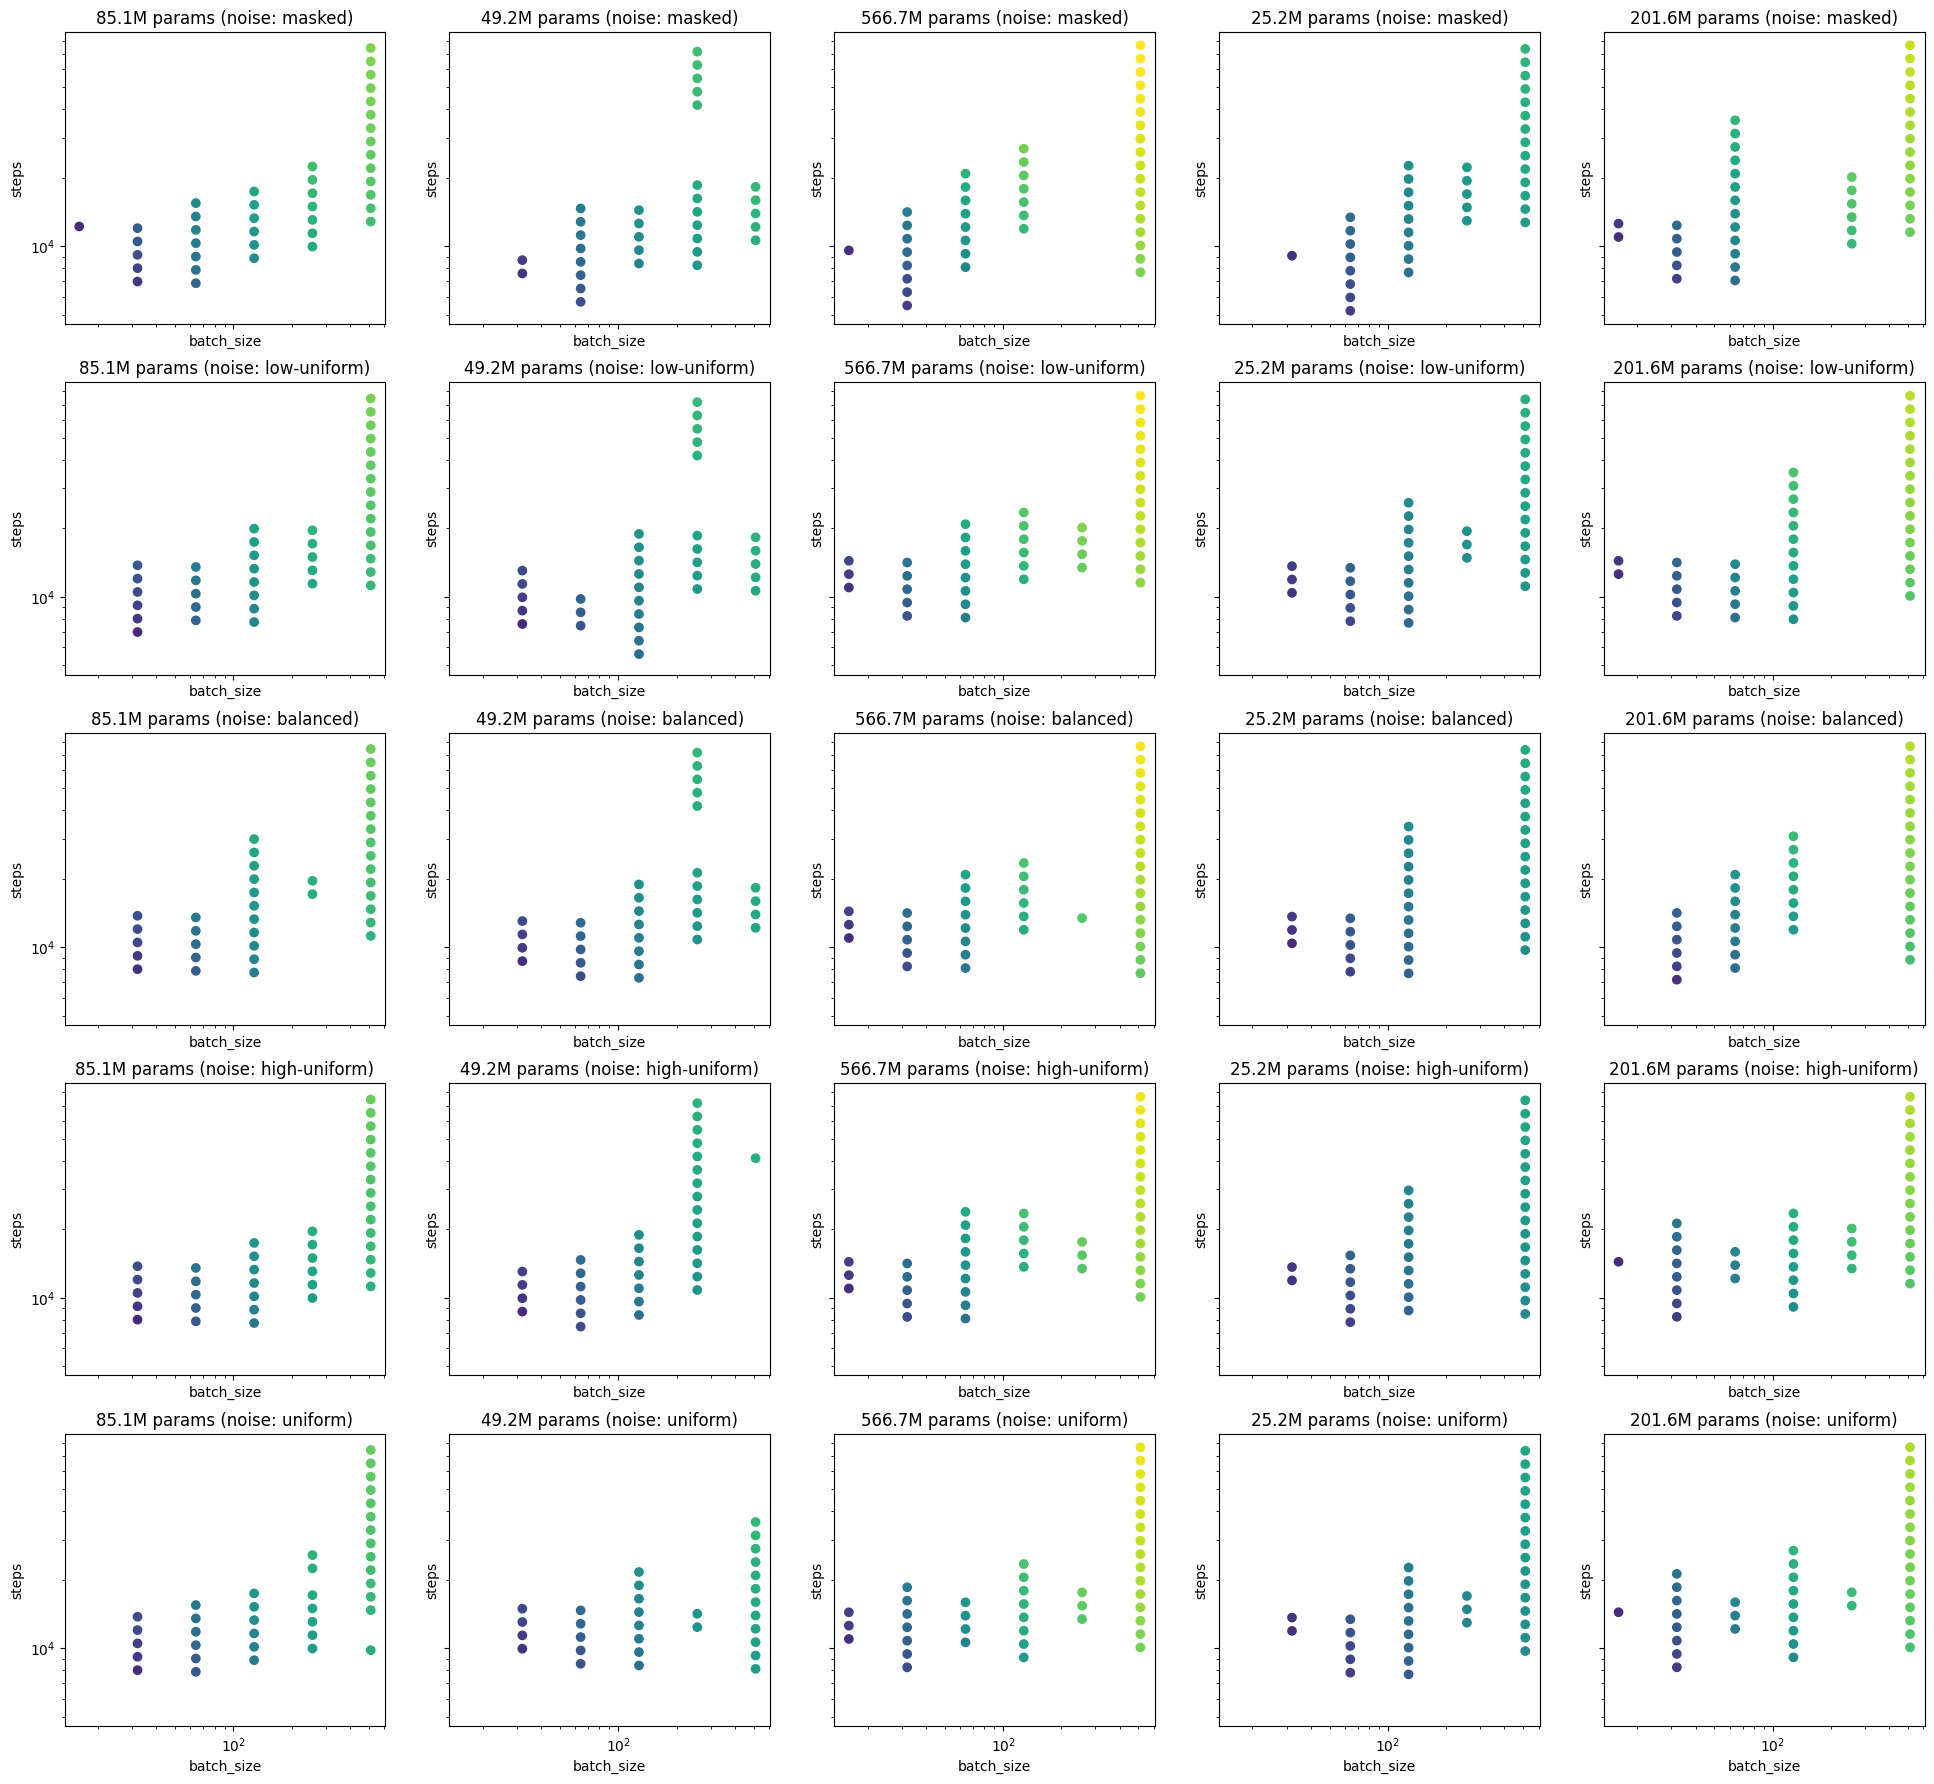

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x.clip(-10, 10)))

fig, axs = plt.subplots(5, len(df_["non_emb_params"].unique()), figsize=(24, 22), sharex=True, sharey=True)

vmin, vmax = df_["loss"].min(), df_["loss"].max()

for i, ((params, ), dfi) in enumerate(df_grouped.group_by("non_emb_params")):
    for j, ((hybrid_mixing_shift, ), dfj) in enumerate(dfi.sort("hybrid_mixing_shift").group_by("hybrid_mixing_shift")):
        ax = axs[j, i]
        # ax.scatter(dfj["batch_size"], dfj["steps"], c=sigmoid(dfj["hybrid_mixing_shift"]))
        ax.scatter(dfj["batch_size"], dfj["steps"], c=dfj["loss"], cmap="viridis_r", vmin=vmin, vmax=vmax)

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("batch_size")
        ax.set_ylabel("steps")
        ax.set_title(f"{params/1e6:.1f}M params (noise: {get_noise_label(hybrid_mixing_shift)})")

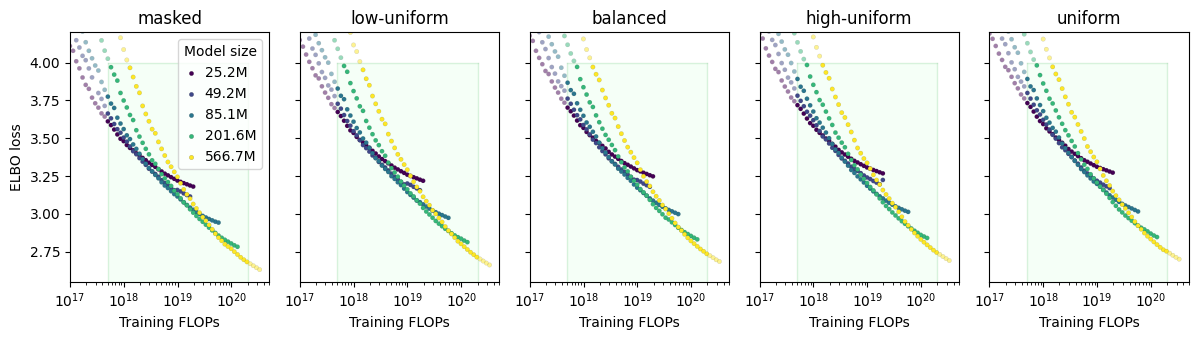

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x.clip(-10, 10)))

fig, axs = plt.subplots(1, 5, figsize=(12, 3.5), sharex=True, sharey=True)

df_ = df.filter(pl.col("loss").is_not_null())
df_ = df_.filter(pl.col("batch_size") < 1024)
df_ = df_.group_by("hybrid_mixing_shift", "non_emb_params", "target_flops").agg(pl.all().sort_by("loss").first())
df_ = df_.filter((pl.col("steps") <= 80000) & (pl.col("steps") > 5000))

vmin, vmax = np.log(df_["non_emb_params"].min()), np.log(df_["non_emb_params"].max())

for i, ((hybrid_mixing_shift, ), dfi) in enumerate(df_.sort("hybrid_mixing_shift").group_by("hybrid_mixing_shift")):
    ax = axs[i]
    # ax.scatter(dfj["batch_size"], dfj["steps"], c=sigmoid(dfj["hybrid_mixing_shift"]))
    for _, dfj in dfi.sort("non_emb_params").group_by("non_emb_params"):
        xs, ys, cs = dfj["target_flops"].to_numpy(), dfj["loss"].to_numpy(), np.log(dfj["non_emb_params"].to_numpy())
        steps = dfj["steps"].to_numpy()
        mask = (xs >= 5e17) & (xs <= 2e20) & (ys < 4.0)
        ax.scatter(xs[mask], ys[mask], c=cs[mask], s=10, edgecolor=(0,0,0,0.2), linewidth=0.3, cmap="viridis", vmin=vmin, vmax=vmax)
        ax.scatter(xs[~mask], ys[~mask], c=cs[~mask], s=10, edgecolor=(0.5, 0.5, 0.5, 0.2), linewidth=0.2, alpha=0.5, cmap="viridis", vmin=vmin, vmax=vmax)

    ax.set_xscale("log")
    ax.set_ylim(2.55, 4.2)
    ax.set_xlim(1e17, None)
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
    # ax.fill_betweenx(ylim, 1e15, 5e17, color=(1.0, 0.0, 0.1, 0.04), zorder=-1)
    ax.fill_betweenx([ylim[0], 4.0], 5e17, 2e20, color=(0.0, 1.0, 0.2, 0.04), linestyle="-", linewidth=1.0, zorder=-1)
    ax.plot([5e17, 5e17], [ylim[0], 4.0], color=(0.0, 0.5, 0.1, 0.1), linestyle="-", linewidth=1.0, zorder=-1)
    ax.plot([5e17, 2e20], [4.0, 4.0], color=(0.0, 0.5, 0.1, 0.1), linestyle="-", linewidth=1.0, zorder=-1)
    ax.plot([2e20, 2e20], [ylim[0], 4.0], color=(0.0, 0.5, 0.1, 0.1), linestyle="-", linewidth=1.0, zorder=-1)
    # ax.fill_betweenx(ylim, 2e20, 1e25, color=(1.0, 0.0, 0.1, 0.04), zorder=-1)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    # ax.set_yscale("log")
    ax.set_xlabel("Training FLOPs")
    ax.set_title(f"{get_noise_label(hybrid_mixing_shift)}")

    if i == 0:
        ax.set_ylabel("ELBO loss")
        for num_params in sorted(dfi["non_emb_params"].unique()):
            ax.scatter([0], [3.0], c=np.log(num_params), vmin=vmin, vmax=vmax, s=10, edgecolor=(0,0,0,0.3), linewidth=0.3, label=f"{num_params/1e6:.1f}M")
        ax.legend(loc="upper right", title="Model size", handlelength=1.0, handletextpad=0.5)

fig.tight_layout()

In [7]:
from concurrent.futures import ProcessPoolExecutor, as_completed

min_flops = 5e17
max_flops = 2e20
lsq_loss = "huber"


def power_law_decay_2d(X, Y, a, alpha, b, beta, E):
    return a * X**-alpha + b * Y**-beta + E

def power_law_decay_1d(X, a, alpha, E=0.0):
    return a * X**-alpha #+ E

def power_law_growth_1d(X, a, alpha, E=0.0):
    return a * X**alpha #+ E

def identity(x):
    return x

def base_resid(f, y, p, transform=np.log):
    return transform(f(*p)) - transform(y)

def bootstrap_fit(xs, ys, p0, func, bounds, seed):
    rng = np.random.default_rng(seed)
    indices = rng.integers(0, len(xs), len(xs))
    xs_bs = xs[indices]
    ys_bs = ys[indices]
    resid_bs = functools.partial(base_resid, functools.partial(func, xs_bs), ys_bs)
    sol_bs = least_squares(resid_bs, p0, bounds=bounds, loss=lsq_loss)
    return sol_bs.x

def fit_scaling_law(df, func, x_key, y_key, p0, bounds=(1e-8, np.inf), lsq_loss=lsq_loss, flops_key="total_flops", min_flops=min_flops, max_flops=max_flops, n_bootstraps=10000, executor=None, n_jobs=-1, show_progress=False):
    flops = df[flops_key].to_numpy().astype(np.float64)
    mask = (flops >= min_flops) & (flops <= max_flops)
    bounds = np.array([np.sign(p0) * np.array(bounds[0] * np.ones(len(p0))), np.sign(p0) * np.array(bounds[1] * np.ones(len(p0)))])
    bounds = np.sort(bounds, axis=0)
    
    x = df[x_key].to_numpy().astype(np.float64)
    y = df[y_key].to_numpy().astype(np.float64)
    x_masked = x[mask]
    y_masked = y[mask]

    resid = functools.partial(base_resid, functools.partial(func, x_masked), y_masked)
    sol = least_squares(resid, p0, bounds=bounds, loss=lsq_loss)

    r2 = 1 - np.sum(resid(sol.x)**2) / np.sum((np.log(y_masked) - np.mean(np.log(y_masked)))**2)

    bootstrap_params = None
    if n_bootstraps > 0:
        seeds = list(range(n_bootstraps))
        bootstrap_params = []
        created_executor = False

        try:
            if executor is None:
                executor = ProcessPoolExecutor(max_workers=n_jobs if n_jobs > 0 else None)
                created_executor = True
            futures = [executor.submit(bootstrap_fit, x_masked, y_masked, sol.x, func, bounds, seed) for seed in seeds]
            for future in tqdm(as_completed(futures), total=len(futures), disable=not show_progress):
                bootstrap_params.append(future.result())
        finally:
            if created_executor:
                executor.shutdown(wait=True)
            
        bootstrap_params = np.array(bootstrap_params)

    return {
        "df": df,
        "x_key": x_key,
        "y_key": y_key,
        "flops_key": flops_key,
        "func": func,
        "resid": resid,
        "args": (x,),
        "mask": mask,
        "y": y,
        "p": sol.x,
        "p_bootstrap": bootstrap_params,
        "r2": r2,
    }


def get_optima(target_flops, tokens, params, flops_per_tok, loss):
    # fit parabola through points
    coeff = np.polyfit(np.log(tokens), np.log(loss), 2)
    opt_tokens = np.exp(-coeff[1] / (2 * coeff[0]))
    opt_loss_by_tokens = np.exp(np.polyval(coeff, np.log(opt_tokens)))

    coeff = np.polyfit(np.log(params), np.log(loss), 2)
    opt_params = np.exp(-coeff[1] / (2 * coeff[0]))

    coeff = np.polyfit(np.log(flops_per_tok), np.log(loss), 2)
    opt_flops_per_tok = np.exp(-coeff[1] / (2 * coeff[0]))
    
    flops_per_param = opt_flops_per_tok / opt_params

    return {
        "target_flops": target_flops,
        "total_flops": opt_tokens * opt_flops_per_tok,
        "opt_tokens": opt_tokens,
        "opt_params": opt_params,
        "opt_flops_per_tok": opt_flops_per_tok,
        "opt_loss": opt_loss_by_tokens,
        "flops_per_param": flops_per_param,
    }

def get_scaling_data(dfi, params_key="non_emb_params", tokens_key="tokens", flops_per_tok_key="flops_per_tok", loss_key="loss"):
    data = []
    for (target_flops,), dfj in dfi.group_by("target_flops"):
        if len(dfj) < 3:
            continue
        params = dfj[params_key]
        tokens = dfj[tokens_key]
        flops_per_tok = dfj[flops_per_tok_key]
        loss = dfj[loss_key]
        
        data.append(get_optima(target_flops, tokens, params, flops_per_tok, loss))
    df = pl.DataFrame(data)
    return df


In [8]:
scaling_laws = {}
n_bootstraps = 10000
# n_bootstraps = 10
n_jobs = -1

fits_per_group = 28

with (
    ProcessPoolExecutor(max_workers=n_jobs if n_jobs > 0 else None) as executor,
    tqdm(total=fits_per_group * len(df_grouped["hybrid_mixing_shift"].unique())) as pbar,
):
    for i, hybrid_mixing_shift in enumerate(df_grouped["hybrid_mixing_shift"].unique()):
        scaling_law = {}
        dfi = df_grouped.filter(pl.col("hybrid_mixing_shift") == hybrid_mixing_shift)
        dfi_approx = df_grouped_approx.filter(pl.col("hybrid_mixing_shift") == hybrid_mixing_shift).clone()
        dfi_approx = dfi_approx.drop("tokens", "flops_per_tok", "loss", "steps").rename({
            "approx_tokens": "tokens",
            "approx_flops_per_tok": "flops_per_tok",
            "approx_loss": "loss",
            "approx_steps": "steps",
        })

        #### HOFFMANN (Chinchilla) ####

        M = dfi["flops_per_tok"].to_numpy().astype(np.float64)
        D = dfi["tokens"].to_numpy().astype(np.float64)
        L = dfi["loss"].to_numpy().astype(np.float64)
        C = M * D
        mask = (C >= min_flops) & (C <= max_flops)

        func = power_law_decay_2d
        resid = functools.partial(base_resid, functools.partial(func, M[mask], D[mask]), L[mask])
        
        p_0 = (20.0, 0.23, 300.0, 0.29, 1.0)
        sol = least_squares(resid, p_0, bounds=(1e-8, np.inf), loss=lsq_loss)
        r2 = 1 - np.sum(resid(sol.x)**2) / np.sum((np.log(L[mask]) - np.mean(np.log(L[mask])))**2)

        print(f"Fit {get_noise_label(hybrid_mixing_shift)+':':16s} a={sol.x[0]:.3g},\talpha={sol.x[1]:.3g},\tb={sol.x[2]:.3g},\tbeta={sol.x[3]:.3g},\tE={sol.x[4]:.3g}")

        scaling_law["loss_surface"] = {
            "df": dfi,
            "func": func,
            "resid": resid,
            "args": (M, D),
            "mask": mask,
            "y": L,
            "p": sol.x,
            "p_bootstrap": None,
            "r2": r2,
        }
        pbar.update(1)

        M = dfi_approx["flops_per_tok"].to_numpy().astype(np.float64)
        D = dfi_approx["tokens"].to_numpy().astype(np.float64)
        L = dfi_approx["loss"].to_numpy().astype(np.float64)
        C = M * D
        mask = (C >= min_flops) & (C <= max_flops)

        func = power_law_decay_2d
        resid = functools.partial(base_resid, functools.partial(func, M[mask], D[mask]), L[mask])
        
        p_0 = (20.0, 0.23, 300.0, 0.29, 1.0)
        sol = least_squares(resid, p_0, bounds=(1e-8, np.inf), loss=lsq_loss)
        r2 = 1 - np.sum(resid(sol.x)**2) / np.sum((np.log(L[mask]) - np.mean(np.log(L[mask])))**2)

        scaling_law["loss_surface"] = {
            "df": dfi_approx,
            "func": func,
            "resid": resid,
            "args": (M, D),
            "mask": mask,
            "y": L,
            "p": sol.x,
            "p_bootstrap": None,
            "r2": r2,
        }
        pbar.update(1)

        #### END HOFFMANN ####


        #### IsoFLOP-based (interpolated) ####

        dfj = get_scaling_data(dfi)
        dfj_approx = get_scaling_data(dfi_approx)

        args = [
            ("opt_tokens", power_law_growth_1d, (1.0, 0.5, 1e-8)),
            ("opt_flops_per_tok", power_law_growth_1d, (1.0, 0.5, 1e-8)),
            ("opt_params", power_law_growth_1d, (1.0, 0.5, 1e-8)),
            ("opt_loss", power_law_growth_1d, (30.0, -0.1, 0.1)),
        ]

        for dfk, name in [(dfj, "deepseek"), (dfj_approx, "chinchilla")]:
            for y_key, func, p0 in args:
                fit = fit_scaling_law(dfk, func, "target_flops", y_key, p0, executor=executor, n_bootstraps=n_bootstraps)
                scaling_law[(name, y_key)] = fit
                pbar.update(1)

        #### END IsoFLOP-based (interpolated) ####


        #### Data-constrained (interpolated) ####

        args = [
            ("opt_flops_per_tok", power_law_growth_1d, (1.0, 0.5, 1e-8)),
            ("opt_loss", power_law_growth_1d, (30.0, -0.1, 0.1)),
        ]

        for dfk, name in [(dfj, "deepseek"), (dfj_approx, "chinchilla")]:
            for y_key, func, p0 in args:
                fit = fit_scaling_law(dfk, func, "opt_tokens", y_key, p0, executor=executor, n_bootstraps=n_bootstraps)
                scaling_law[(name, f"tokens-{y_key}")] = fit
                pbar.update(1)

        #### END Data-constrained (interpolated) ####

        #### IsoFLOP-based (raw) ####

        dfj = dfi.group_by("target_flops").agg(pl.all().sort_by("loss").first()).sort("flops_per_tok")
        dfj_approx = dfi_approx.group_by("target_flops").agg(pl.all().sort_by("loss").first()).sort("flops_per_tok")

        args = [
            ("tokens", power_law_growth_1d, (1.0, 0.5, 1e-8)),
            ("flops_per_tok", power_law_growth_1d, (1.0, 0.5, 1e-8)),
            ("non_emb_params", power_law_growth_1d, (1.0, 0.5, 1e-8)),
            ("loss", power_law_growth_1d, (30.0, -0.1, 0.1)),
        ]

        for dfk, name in [(dfj, "deepseek_raw"), (dfj_approx, "chinchilla_raw")]:
            for y_key, func, p0 in args:
                fit = fit_scaling_law(dfk, func, "target_flops", y_key, p0, executor=executor, n_bootstraps=n_bootstraps)
                scaling_law[(name, y_key)] = fit
                pbar.update(1)

        #### END IsoFLOP-based (raw) ####

        #### Data-constrained (raw) ####

        args = [
            ("flops_per_tok", power_law_growth_1d, (1.0, 0.5, 1e-8)),
            ("loss", power_law_growth_1d, (30.0, -0.1, 0.1)),
        ]

        for dfk, name in [(dfj, "deepseek_raw"), (dfj_approx, "chinchilla_raw")]:
            for y_key, func, p0 in args:
                fit = fit_scaling_law(dfk, func, "tokens", y_key, p0, executor=executor, n_bootstraps=n_bootstraps)
                scaling_law[(name, f"tokens-{y_key}")] = fit
                pbar.update(1)

        #### END Data-constrained (raw) ####


        #### Compute-optimal frontier (direct) ####

        for dfk, name in [(dfj, "deepseek"), (dfj_approx, "chinchilla")]:
            fit = fit_scaling_law(dfj, power_law_growth_1d, "target_flops", "loss", (30.0, -0.1, 0.1), min_flops=1e17, max_flops=1e22, executor=executor, n_bootstraps=n_bootstraps)
            scaling_law[(name, "compute_optimal_loss_direct")] = fit
            pbar.update(1)

        #### END Compute-optimal frontier (direct) ####

        scaling_laws[hybrid_mixing_shift] = scaling_law

  0%|          | 0/140 [00:00<?, ?it/s]

Fit masked:          a=222,	alpha=0.292,	b=1.92e+03,	beta=0.367,	E=2.17
Fit low-uniform:     a=477,	alpha=0.335,	b=1.88e+03,	beta=0.365,	E=2.25
Fit balanced:        a=626,	alpha=0.35,	b=1.52e+03,	beta=0.353,	E=2.27
Fit high-uniform:    a=303,	alpha=0.307,	b=1.5e+03,	beta=0.352,	E=2.21
Fit uniform:         a=294,	alpha=0.305,	b=1.34e+03,	beta=0.346,	E=2.19


In [9]:
# pretty_keys = {
#     "tokens": "Tokens ($D$)",
#     "flops_per_tok": "FLOPs per token ($M$)",
#     "non_emb_params": "Non-emb. params. ($P$)",
#     "params": "Non-emb. params. ($P$)",
#     "loss": "Loss ($L$)",
# }

# def format_key(key):
#     return pretty_keys.get(key.replace("opt_", ""))

# print("\\toprule")
# print(f"Noise type & Interp. & \\multicolumn{{3}}{{c}}{{Method 1 (DeepSeek)}} & \\multicolumn{{3}}{{c}}{{Method 2 (Chinchilla)}} \\\\")

# for raw_y_key, fit_y_key in zip(["tokens", "flops_per_tok", "non_emb_params", "loss"], ["opt_tokens", "opt_flops_per_tok", "opt_params", "opt_loss"]):
#     print("\\midrule")
#     print(f"\\multicolumn{{2}}{{l}}{{{format_key(raw_y_key)}}} & $A$ & $\\alpha$ & $E$ & $A$ & $\\alpha$ & $E$ \\\\")
#     print("\\midrule")
#     for i, (interpolation, data_name) in enumerate([("raw", "raw"), ("fit", "sq. fit")]):
#         if i > 0:
#             print("\\midrule")
#         rows = []
#         for hybrid_mixing_shift, scaling_law in scaling_laws.items():
#             noise_label = get_noise_label(hybrid_mixing_shift)
#             if interpolation == "raw":
#                 y_key = raw_y_key
#                 postfix = "_raw"
#             else:
#                 y_key = fit_y_key
#                 postfix = ""
#             p1 = scaling_law[("deepseek" + postfix, y_key)]['p'].copy()
#             p2 = scaling_law[("chinchilla" + postfix, y_key)]['p'].copy()

#             rows.append((noise_label, data_name, p1[0], p1[1], p1[2], p2[0], p2[1], p2[2]))
#         best_alpha_1 = min([r[3] for r in rows])
#         best_alpha_2 = min([r[6] for r in rows])
#         for row in rows:
#             noise_label, data_name, p1_0, p1_1, p1_2, p2_0, p2_1, p2_2 = row
#             if p1_1 == best_alpha_1:
#                 p1_1 = f"\\textbf{{{p1_1:.4f}}}"
#             else:
#                 p1_1 = f"{p1_1:.4f}"

#             if p2_1 == best_alpha_2:
#                 p2_1 = f"\\textbf{{{p2_1:.4f}}}"
#             else:
#                 p2_1 = f"{p2_1:.4f}"
#             print(f"{noise_label:16s} & {data_name:8s} & {p1_0:.4f} & {p1_1} & {p1_2:.4f} & {p2_0:.4f} & {p2_1} & {p2_2:.4f} \\\\")

# print("\\bottomrule")

In [10]:
pretty_keys = {
    "tokens": "Tokens ($D$)",
    "flops_per_tok": "FLOPs per token ($M$)",
    "non_emb_params": "Non-emb. params. ($P$)",
    "params": "Non-emb. params. ($P$)",
    "loss": "Loss ($L$)",
}

def format_key(key):
    return pretty_keys.get(key.replace("opt_", ""))

print("\\toprule")
print(f"Noise type & Interp. & \\multicolumn{{2}}{{c}}{{Method 1 (DeepSeek)}} & \\multicolumn{{2}}{{c}}{{Method 2 (Chinchilla)}} \\\\")

for raw_y_key, fit_y_key in zip(["loss", "tokens", "flops_per_tok", "non_emb_params"], ["opt_loss", "opt_tokens", "opt_flops_per_tok", "opt_params"]):
    print("\\midrule")
    print(f"\\multicolumn{{2}}{{l}}{{{format_key(raw_y_key)}}} & $A$ & $\\alpha$ & $A$ & $\\alpha$ \\\\")
    print("\\midrule")
    for i, (interpolation, data_name) in enumerate([("raw", "raw"), ("fit", "sq. fit")]):
        if i > 0:
            print("\\midrule")
        rows = []
        for hybrid_mixing_shift, scaling_law in scaling_laws.items():
            noise_label = get_noise_label(hybrid_mixing_shift)
            if interpolation == "raw":
                y_key = raw_y_key
                postfix = "_raw"
            else:
                y_key = fit_y_key
                postfix = ""
            p1 = scaling_law[("deepseek" + postfix, y_key)]['p'].copy()
            p2 = scaling_law[("chinchilla" + postfix, y_key)]['p'].copy()

            rows.append((noise_label, data_name, p1[0], p1[1], p1[2], p2[0], p2[1], p2[2]))
        best_alpha_1 = min([r[3] for r in rows])
        best_alpha_2 = min([r[6] for r in rows])
        for row in rows:
            noise_label, data_name, p1_0, p1_1, p1_2, p2_0, p2_1, p2_2 = row
            if p1_1 == best_alpha_1:
                p1_1 = f"\\textbf{{{p1_1:.5f}}}"
            else:
                p1_1 = f"{p1_1:.5f}"

            if p2_1 == best_alpha_2:
                p2_1 = f"\\textbf{{{p2_1:.5f}}}"
            else:
                p2_1 = f"{p2_1:.5f}"
            print(f"{noise_label:16s} & {data_name:8s} & {p1_0:.5f} & {p1_1} & {p2_0:.5f} & {p2_1} \\\\")

print("\\bottomrule")

\toprule
Noise type & Interp. & \multicolumn{2}{c}{Method 1 (DeepSeek)} & \multicolumn{2}{c}{Method 2 (Chinchilla)} \\
\midrule
\multicolumn{2}{l}{Loss ($L$)} & $A$ & $\alpha$ & $A$ & $\alpha$ \\
\midrule
masked           & raw      & 27.41772 & -0.04977 & 23.64593 & -0.04676 \\
low-uniform      & raw      & 28.54100 & -0.05040 & 24.44062 & -0.04724 \\
balanced         & raw      & 29.11304 & -0.05066 & 24.90152 & -0.04748 \\
high-uniform     & raw      & 29.69861 & -0.05103 & 25.48828 & -0.04792 \\
uniform          & raw      & 30.36696 & \textbf{-0.05150} & 25.75001 & \textbf{-0.04812} \\
\midrule
masked           & sq. fit  & 27.21883 & -0.04961 & 23.10227 & -0.04622 \\
low-uniform      & sq. fit  & 29.12047 & -0.05088 & 24.75090 & -0.04755 \\
balanced         & sq. fit  & 29.84096 & -0.05124 & 25.33846 & -0.04789 \\
high-uniform     & sq. fit  & 30.19375 & -0.05141 & 25.92804 & -0.04832 \\
uniform          & sq. fit  & 31.26171 & \textbf{-0.05219} & 26.75888 & \textbf{-0.04903} \\


In [11]:
pretty_keys = {
    "tokens": "Tokens ($D$)",
    "flops_per_tok": "FLOPs per token ($M$)",
    "non_emb_params": "Non-emb. params. ($P$)",
    "params": "Non-emb. params. ($P$)",
    "loss": "Loss ($L$)",
}

def format_key(key):
    return pretty_keys.get(key.replace("opt_", ""))

print("\\toprule")
print(f"Noise type & \\multicolumn{{2}}{{c}}{{Method 1 (DeepSeek)}} & \\multicolumn{{2}}{{c}}{{Method 2 (Chinchilla)}} \\\\")

for raw_y_key, fit_y_key in zip(["loss", "tokens", "flops_per_tok", "non_emb_params"], ["opt_loss", "opt_tokens", "opt_flops_per_tok", "opt_params"]):
    print("\\midrule")
    print(f"\\multicolumn{{1}}{{l}}{{{format_key(raw_y_key)}}} & $R^2$ (raw) & $R^2$ (sq. fit) & $R^2$ (raw) & $R^2$ (sq. fit) \\\\")
    print("\\midrule")
    for hybrid_mixing_shift, scaling_law in scaling_laws.items():
        noise_label = get_noise_label(hybrid_mixing_shift)
        row = []
        for method in ["deepseek", "chinchilla"]:
            for i, (interpolation, data_name) in enumerate([("raw", "raw"), ("fit", "sq. fit")]):
                if interpolation == "raw":
                    y_key = raw_y_key
                    postfix = "_raw"
                else:
                    y_key = fit_y_key
                    postfix = ""
                r2 = scaling_law[(method + postfix, y_key)]['r2']
                row.append(r2)

        best_r2 = max(row)
        row = tuple(f"\\textbf{{{x:.4f}}}" if x == best_r2 else f"{x:.4f}" for x in row)
        print(f"{noise_label:16s} & {row[0]} & {row[1]} & {row[2]} & {row[3]} \\\\")

print("\\bottomrule")

\toprule
Noise type & \multicolumn{2}{c}{Method 1 (DeepSeek)} & \multicolumn{2}{c}{Method 2 (Chinchilla)} \\
\midrule
\multicolumn{1}{l}{Loss ($L$)} & $R^2$ (raw) & $R^2$ (sq. fit) & $R^2$ (raw) & $R^2$ (sq. fit) \\
\midrule
masked           & \textbf{0.9997} & 0.9996 & 0.9997 & 0.9995 \\
low-uniform      & 0.9997 & 0.9997 & \textbf{0.9998} & 0.9996 \\
balanced         & 0.9996 & 0.9997 & \textbf{0.9998} & 0.9997 \\
high-uniform     & \textbf{0.9998} & 0.9995 & 0.9997 & 0.9993 \\
uniform          & 0.9996 & \textbf{0.9998} & 0.9995 & 0.9997 \\
\midrule
\multicolumn{1}{l}{Tokens ($D$)} & $R^2$ (raw) & $R^2$ (sq. fit) & $R^2$ (raw) & $R^2$ (sq. fit) \\
\midrule
masked           & 0.9252 & 0.9891 & 0.8898 & \textbf{0.9919} \\
low-uniform      & 0.9317 & \textbf{0.9955} & 0.9086 & 0.9928 \\
balanced         & 0.9329 & 0.9938 & 0.9110 & \textbf{0.9977} \\
high-uniform     & 0.9370 & 0.9810 & 0.9083 & \textbf{0.9859} \\
uniform          & 0.9344 & 0.9884 & 0.9061 & \textbf{0.9926} \\
\midrul

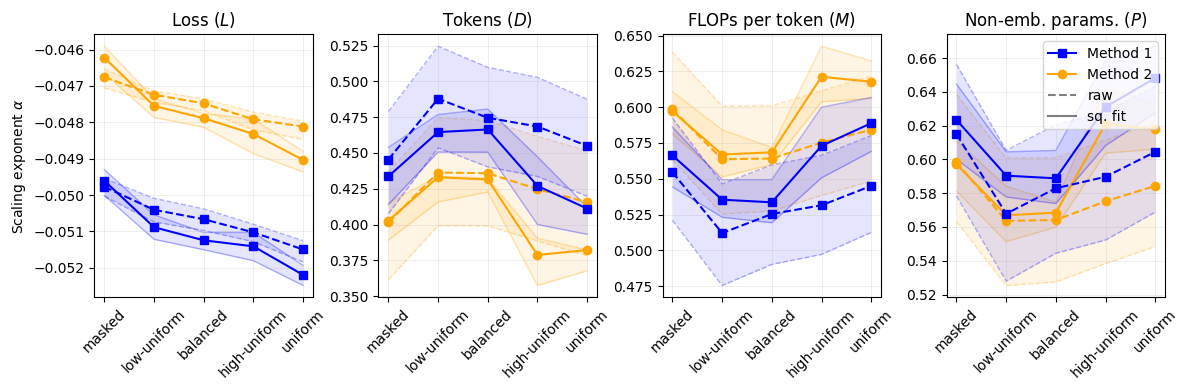

In [12]:
pretty_keys = {
    "tokens": "Tokens ($D$)",
    "flops_per_tok": "FLOPs per token ($M$)",
    "non_emb_params": "Non-emb. params. ($P$)",
    "params": "Non-emb. params. ($P$)",
    "loss": "Loss ($L$)",
}

def format_key(key):
    return pretty_keys.get(key.replace("opt_", ""))

def get_confidence_bounds(p_bootstrap, alpha=0.05):
    lower = np.percentile(p_bootstrap, 100 * (alpha / 2), axis=0)
    upper = np.percentile(p_bootstrap, 100 * (1 - alpha / 2), axis=0)
    return lower, upper

fig, axs = plt.subplots(1, 4, figsize=(12, 4))
plt_idx = 0
for raw_y_key, fit_y_key in zip(["loss", "tokens", "flops_per_tok", "non_emb_params"], ["opt_loss", "opt_tokens", "opt_flops_per_tok", "opt_params"]):
    ax = axs[plt_idx]
    plt_idx += 1
    for method, method_name, color, marker in [("chinchilla", "Method 2 (Chinchilla)", "orange", "o"), ("deepseek", "Method 1 (DeepSeek)", "blue", "s")]:
        xlabels = []
        ys_raw = []
        ys_fit = []
        lower_raw = []
        upper_raw = []
        lower_fit = []
        upper_fit = []
        for hybrid_mixing_shift, scaling_law in scaling_laws.items():
            xlabels.append(get_noise_label(hybrid_mixing_shift))
            ys_fit.append(scaling_law[(method, fit_y_key)]['p'][1])
            ys_raw.append(scaling_law[(method + "_raw", raw_y_key)]['p'][1])
            l_raw, u_raw = get_confidence_bounds(scaling_law[(method + "_raw", raw_y_key)]['p_bootstrap'][:, 1])
            l_fit, u_fit = get_confidence_bounds(scaling_law[(method, fit_y_key)]['p_bootstrap'][:, 1])
            lower_raw.append(l_raw)
            upper_raw.append(u_raw)
            lower_fit.append(l_fit)
            upper_fit.append(u_fit)

        ax.fill_between(xlabels, lower_raw, upper_raw, color=color, alpha=0.1, linewidth=0, zorder=1)
        ax.plot(xlabels, lower_raw, marker=None, linestyle="--", color=color, alpha=0.3, linewidth=1.0, zorder=1)
        ax.plot(xlabels, upper_raw, marker=None, linestyle="--", color=color, alpha=0.3, linewidth=1.0, zorder=1)
        ax.fill_between(xlabels, lower_fit, upper_fit, color=color, alpha=0.1, linewidth=0, zorder=1)
        ax.plot(xlabels, lower_fit, marker=None, linestyle="-", color=color, alpha=0.3, linewidth=1.0, zorder=1)
        ax.plot(xlabels, upper_fit, marker=None, linestyle="-", color=color, alpha=0.3, linewidth=1.0, zorder=1)
        ax.plot(xlabels, ys_raw, marker=marker, linestyle="--", color=color, zorder=5)
        ax.plot(xlabels, ys_fit, marker=marker, linestyle="-", color=color, zorder=5)

    if plt_idx == 1:
        ax.set_ylabel("Scaling exponent $\\alpha$")

    if plt_idx == 4:
        ax.plot([], [], marker="s", linestyle="-", color="blue", label="Method 1")
        ax.plot([], [], marker="o", linestyle="-", color="orange", label="Method 2")
        ax.plot([], [], marker="none", linestyle="--", alpha=0.5, color="black", label="raw")
        ax.plot([], [], marker="none", linestyle="-", alpha=0.5, color="black", label="sq. fit")
        ax.legend(loc="upper right")
    ax.set_title(format_key(raw_y_key))

    ax.grid(True, which="both", linestyle="-", linewidth=0.5, alpha=0.3)

    ax.set_xticks(xlabels)
    ax.set_xticklabels(xlabels, rotation=45)
fig.tight_layout(w_pad=0.1)
fig.savefig("plots/scaling_exponents.pdf", bbox_inches="tight")

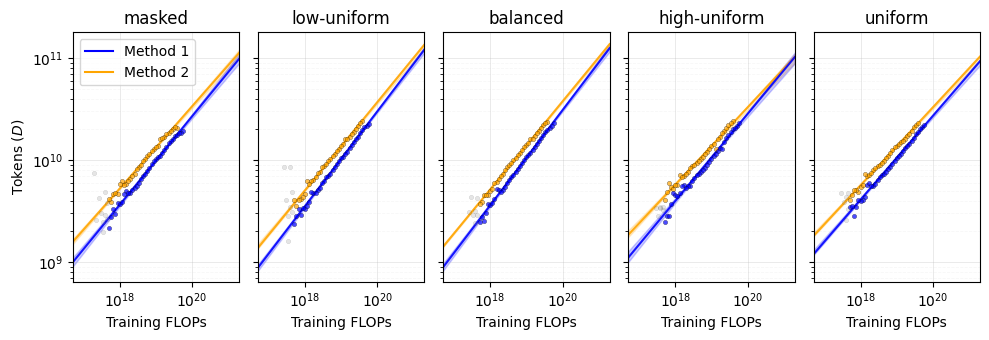

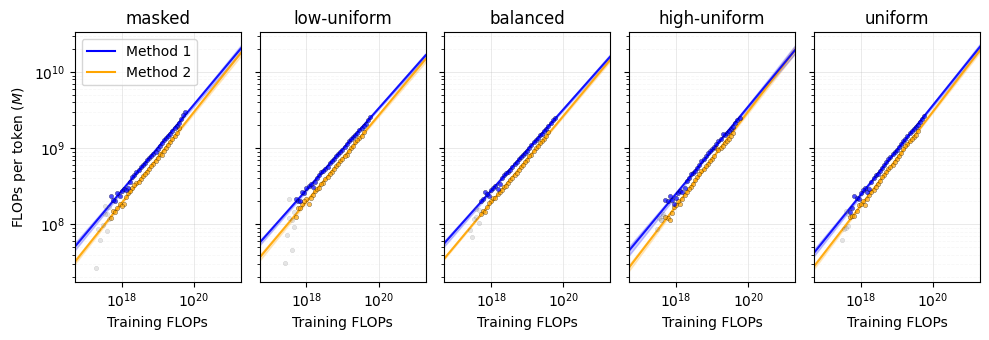

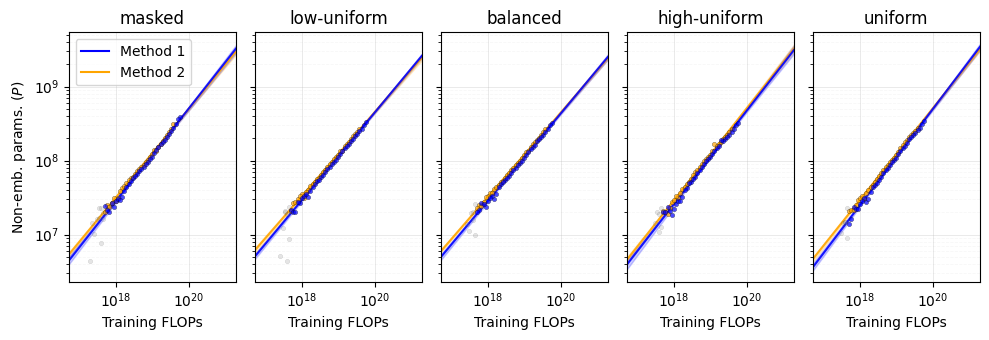

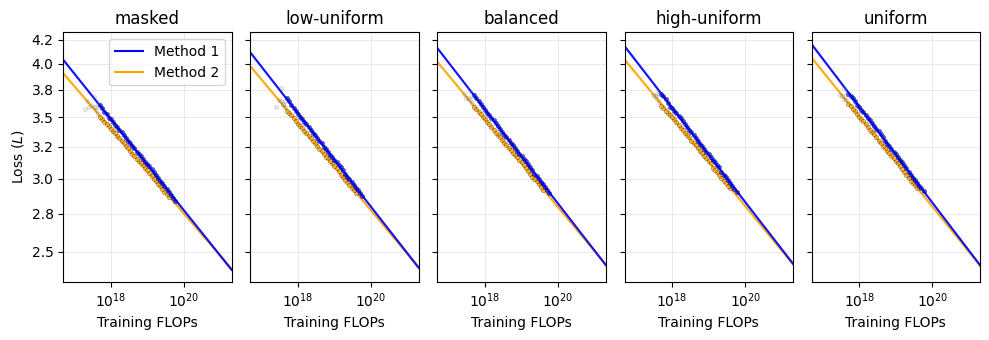

In [13]:
pretty_keys = {
    "tokens": "Tokens ($D$)",
    "flops_per_tok": "FLOPs per token ($M$)",
    "non_emb_params": "Non-emb. params. ($P$)",
    "params": "Non-emb. params. ($P$)",
    "loss": "Loss ($L$)",
}

symbols = {
    "tokens": "D",
    "flops_per_tok": "M",
    "non_emb_params": "P",
    "params": "P",
    "loss": "L",
}

def format_key(key):
    return pretty_keys.get(key.replace("opt_", ""))

def get_symbol(key):
    return symbols.get(key.replace("opt_", ""))

def get_confidence_bounds(law, xs, alpha=0.05):
    ys = law["func"](xs[None, :], *(law["p_bootstrap"].T[:, :, None]))
    lower = np.percentile(ys, 100 * (alpha / 2), axis=0)
    upper = np.percentile(ys, 100 * (1 - alpha / 2), axis=0)
    return lower, upper

def plot_scaling_law(ax, scaling_law, x_symbol="C", y_symbol="L", min_x=5e16, max_x=2e21, growing=False, unit="nats", color="C3"):
    if unit == "bpb":
        scale = 0.34124
    else:
        scale = 1.0

    x = scaling_law["args"][0]
    y = scaling_law["y"]
    mask = scaling_law["mask"]

    ax.scatter(x[mask], scale * y[mask], c=color, alpha=0.7, s=10, edgecolor=(0,0,0,0.1), linewidth=0.25, zorder=5)
    ax.scatter(x[~mask], scale * y[~mask], c="gray", alpha=0.2, s=10, edgecolor=(0,0,0,0.1), linewidth=0.25, zorder=5)

    p = scaling_law["p"]
    a, alpha = scale * p[0], -p[1]
    if growing:
        alpha = -alpha
    label = f"{y_symbol} = {a:.3g} \\cdot {x_symbol}^{{{alpha:.3g}}}"
    if len(p) > 2:
        if p[2] < 1e-7:
            label += f"+ 0.0"
        elif p[2] < 1e-3:
            label += f"+ 10^{{{np.log10(p[2]):.2f}}}"
        else:
            label += f"+ {p[2]:.3g}"


    xs = np.logspace(np.log10(min_x), np.log10(max_x), 100)
    lower, upper = get_confidence_bounds(scaling_law, xs)
    ax.fill_between(xs, scale * lower, scale * upper, color=color, alpha=0.2)
    y_star = scaling_law["func"](xs, *scaling_law["p"])
    ax.plot(xs, scale * y_star, linestyle="-", color=color, alpha=0.9)

    # handles, labels = ax.get_legend_handles_labels()

    # leg_main = ax.legend(handles, labels)
    # ax.add_artist(leg_main)


for y_key in ["opt_tokens", "opt_flops_per_tok", "opt_params", "opt_loss"]:
    fig, axs = plt.subplots(1, 5, figsize=(10, 3.5), sharey=True)
    plt_idx = 0
    for hybrid_mixing_shift, scaling_law in scaling_laws.items():
        ax = axs[plt_idx]
        plt_idx += 1
        for method, method_name, color, marker in [("chinchilla", "Method 2 (Chinchilla)", "orange", "o"), ("deepseek", "Method 1 (DeepSeek)", "blue", "s")]:
            law = scaling_law[(method, y_key)]
            plot_scaling_law(ax, law, x_symbol="C", y_symbol=get_symbol(y_key), min_x=5e16, max_x=2e21, growing=True, unit="nats", color=color)

        if plt_idx == 1:
            ax.set_ylabel(format_key(y_key))
            ax.plot([], [], linestyle="-", color="blue", label="Method 1")
            ax.plot([], [], linestyle="-", color="orange", label="Method 2")
            ax.legend()
        ax.set_xlabel("Training FLOPs")
        ax.set_title(get_noise_label(hybrid_mixing_shift))
        ax.set_xscale("log")
        ax.set_xlim(5e16, 2e21)
        if "loss" not in y_key:
            ax.set_yscale("log")
        else:
            ax.set_yscale("linear")
            yticks = ax.get_yticks()
            ax.set_yscale("log")
            y_min, y_max = ax.get_ylim()
            yticks = yticks[(yticks >= y_min) & (yticks <= y_max)]
            ax.set_yticks(yticks)
            ax.set_yticklabels([f"{y:.1f}" for y in yticks])

        ax.grid(True, which="minor", linestyle="--", linewidth=0.6, alpha=0.1)
        ax.grid(True, which="major", linestyle="-", linewidth=0.6, alpha=0.3)

    fig.tight_layout(w_pad=1.0)
    fig.show()
    fig.savefig(f"plots/scaling_law-fit-{y_key}.pdf", bbox_inches="tight")

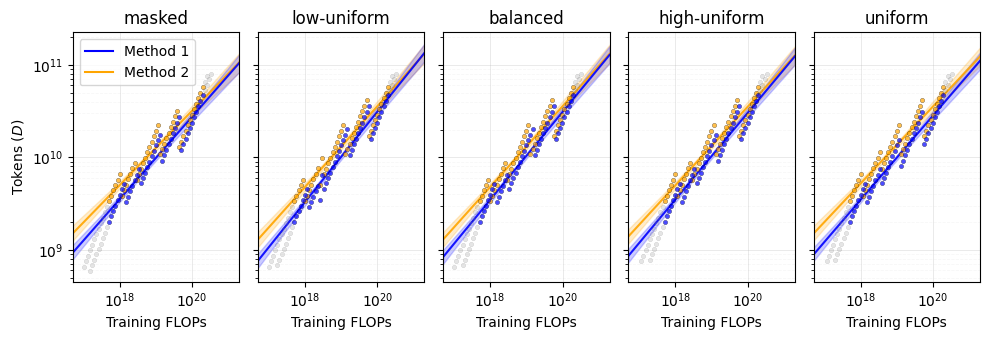

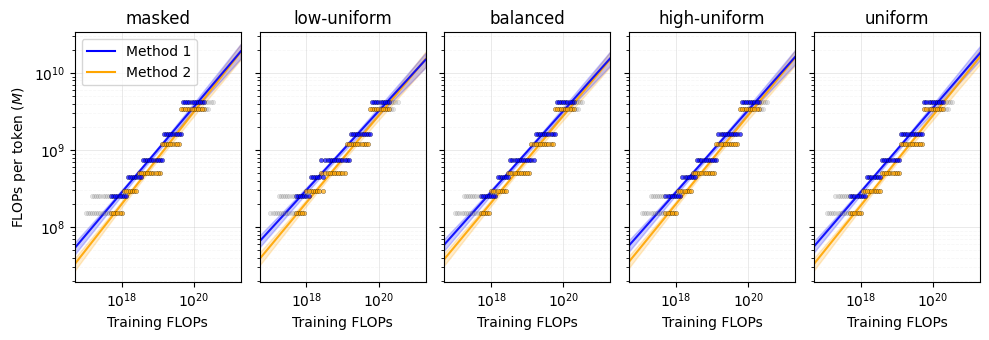

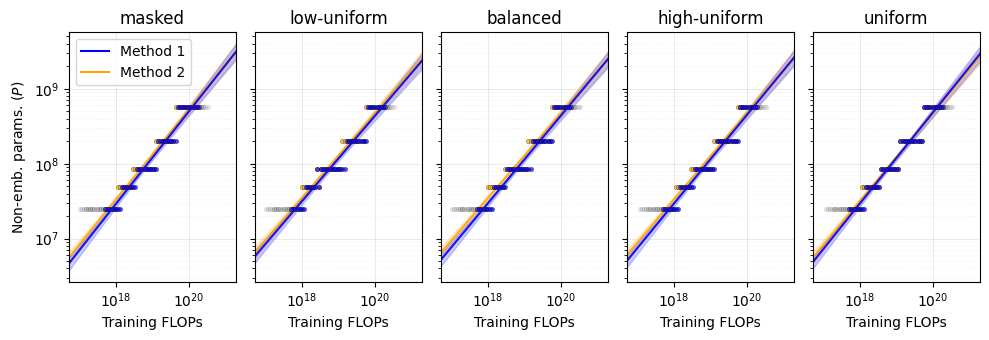

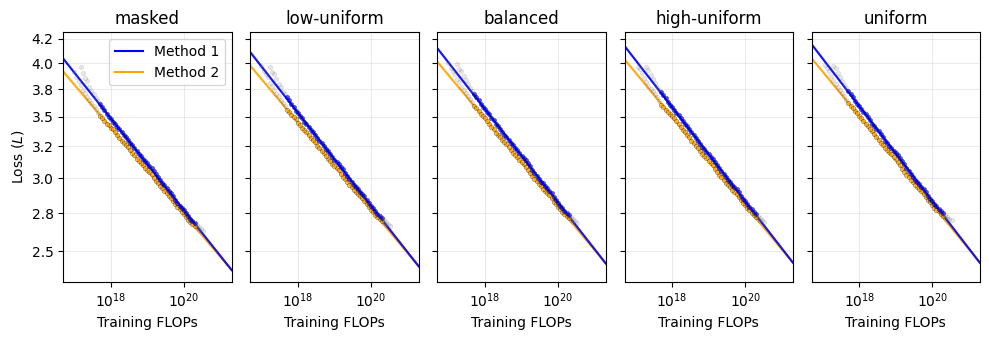

In [14]:
for y_key in ["tokens", "flops_per_tok", "non_emb_params", "loss"]:
    fig, axs = plt.subplots(1, 5, figsize=(10, 3.5), sharey=True)
    plt_idx = 0
    for hybrid_mixing_shift, scaling_law in scaling_laws.items():
        ax = axs[plt_idx]
        plt_idx += 1
        for method, method_name, color, marker in [("chinchilla_raw", "Method 2 (Chinchilla)", "orange", "o"), ("deepseek_raw", "Method 1 (DeepSeek)", "blue", "s")]:
            law = scaling_law[(method, y_key)]
            plot_scaling_law(ax, law, x_symbol="C", y_symbol=get_symbol(y_key), min_x=5e16, max_x=2e21, growing=True, unit="nats", color=color)

        if plt_idx == 1:
            ax.set_ylabel(format_key(y_key))
            ax.plot([], [], linestyle="-", color="blue", label="Method 1")
            ax.plot([], [], linestyle="-", color="orange", label="Method 2")
            ax.legend()
        ax.set_xlabel("Training FLOPs")
        ax.set_title(get_noise_label(hybrid_mixing_shift))
        ax.set_xscale("log")
        ax.set_xlim(5e16, 2e21)
        if "loss" not in y_key:
            ax.set_yscale("log")
        else:
            ax.set_yscale("linear")
            yticks = ax.get_yticks()
            ax.set_yscale("log")
            y_min, y_max = ax.get_ylim()
            yticks = yticks[(yticks >= y_min) & (yticks <= y_max)]
            ax.set_yticks(yticks)
            ax.set_yticklabels([f"{y:.1f}" for y in yticks])

        ax.grid(True, which="minor", linestyle="--", linewidth=0.6, alpha=0.1)
        ax.grid(True, which="major", linestyle="-", linewidth=0.6, alpha=0.3)

    fig.tight_layout(w_pad=1.0)
    fig.show()
    fig.savefig(f"plots/scaling_law-raw-{y_key}.pdf", bbox_inches="tight")

1e+18 1.0317582003185
1e+22 1.0074652428167097
[36.09327719  0.09298918  0.43509722]


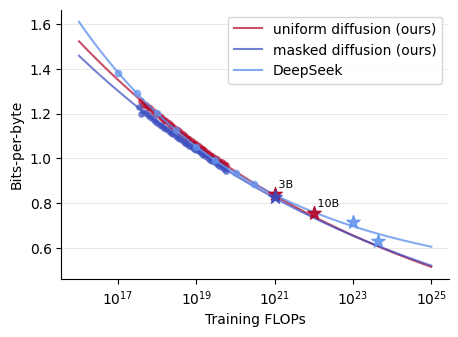

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

nll_to_bpb = 0.34124
cooldown_factor = 1.0245

plt.figure(figsize=(5,3.5))
ax = plt.gca()

c = np.array(colors[1000.0]) / 255.0
scaling_law = scaling_laws[1000.0][("deepseek", "opt_loss")]
x = scaling_law["args"][0]
y = scaling_law["y"]
mask = scaling_law["mask"]

plt.scatter(x, nll_to_bpb * y / cooldown_factor, color=c, s=20, alpha=0.7, linewidth=0.25)

x_fit = np.logspace(16, 25, 100)
y_fit = scaling_law["func"](x_fit, *scaling_law["p"])
plt.plot(x_fit, nll_to_bpb * y_fit / cooldown_factor, color=c, linestyle="-", alpha=0.7, label="uniform diffusion (ours)")
plt.scatter([1e21, 1e22], [nll_to_bpb * 2.462, nll_to_bpb * 2.214], color=c, marker="*", s=100, alpha=0.9, zorder=15)
# plt.scatter([1e21, 1e22], [nll_to_bpb * 2.462 * 1.0245, nll_to_bpb * 2.214 * 1.0245], color=c, marker="*", alpha=0.9, zorder=15)

plt.text(1e21, nll_to_bpb * 2.462 + 0.02, " 3B", verticalalignment="bottom", fontsize=8, zorder=16)
plt.text(1e22, nll_to_bpb * 2.214 + 0.02, " 10B", verticalalignment="bottom", fontsize=8, zorder=16)


c = np.array(colors[-1000.0]) / 255.0
scaling_law = scaling_laws[-1000.0][("deepseek", "opt_loss")]
x = scaling_law["args"][0]
y = scaling_law["y"]
mask = scaling_law["mask"]

plt.scatter(x, nll_to_bpb * y / cooldown_factor, color=c, s=20, alpha=0.7, linewidth=0.25)

prev_y = y_fit
x_fit = np.logspace(16, 25, 100)
y_fit = scaling_law["func"](x_fit, *scaling_law["p"])
plt.plot(x_fit, nll_to_bpb * y_fit / cooldown_factor, color=c, linestyle="-", alpha=0.7, label="masked diffusion (ours)")

print(x_fit[22], (prev_y / y_fit)[22])
print(x_fit[66], (prev_y / y_fit)[66])

plt.scatter([1e21], [nll_to_bpb * 2.422], color=c, marker="*", s=100, alpha=0.9, zorder=15)
# plt.scatter([1e21], [nll_to_bpb * 2.422 * 1.0245], color=c, marker="*", alpha=0.9, zorder=15)

# --------------------------------

def power_law(flops, a=36.09327977, alpha=0.09298918, E=0.43509723):
    return a * flops ** -alpha + E

unit = 641
offset = 0.4
ys = np.array([629/unit + offset, 572/unit + offset, 513/unit + offset, 466/unit + offset, 416/unit + offset, 381/unit + offset, 342/unit + offset, 311/unit + offset])
xs = [1e17, 3e17, 1e18, 3e18, 1e19, 3e19, 1e20, 3e20]
plt.scatter(xs, ys, s=20, alpha=0.7, color="cornflowerblue", zorder=10)

# coeff = np.polyfit(np.log(xs), np.log(ys), 1)
# print(f"Fit empirical coeff: {coeff}")

def resid(p):
    a, alpha, E = p
    return np.log(ys) - np.log(power_law(xs, a, alpha, E))

p0 = (30.0, 0.1, 0.4)

sol = least_squares(resid, p0, bounds=(1e-8, np.inf), loss=lsq_loss)

x_fit = np.logspace(16, 25, 100)
y_fit = sol.x[0] * x_fit ** -sol.x[1] + sol.x[2]
plt.plot(x_fit, y_fit, linestyle="-", color="cornflowerblue", alpha=0.8, label="DeepSeek", zorder=10)

print(sol.x)


def deepseek_opt_loss(flops):
    a, alpha, E = sol.x
    return a * flops ** -alpha + E

x1, x2 = 1e23, 4.472e23
y1, y2 = 0.7174904943, 0.6319391635

plt.scatter([x1, x2], [y1, y2], color="cornflowerblue", alpha=0.9, marker="*", s=100, zorder=15)


plt.xscale("log")
# plt.yscale("log")

plt.grid(which="major", axis="y", linestyle="-", linewidth=0.5, alpha=0.4)

plt.xlabel("Training FLOPs")
plt.ylabel("Bits-per-byte")
plt.legend()


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.xlim(1e16, 1e25)
# plt.ylim(0.4, 1.8);
plt.savefig("plots/scaling_law-comparison.pdf", bbox_inches="tight")

|Model|ARC-E|ARC-C|WinoG|PIQA|OBQA|BoolQ|GSM8k|
|-|-|-|-|-|-|-|-|
|mask-3b|49.9|29.4|51.6|64.8|30.6|60.9|1.67|
|unif-3b|50.6|28.0|51.1|63.5|28.8|56.4|2.05|
|unif-10b|61.8|35.7|55.5|66.3|32.8|60.3|2.43|



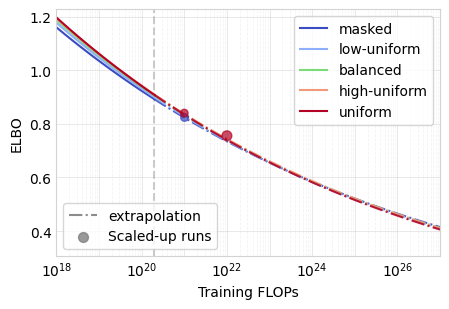

In [16]:

nll_to_bpb = 0.34124
cooldown_factor = 1.0245


def get_color(hybrid_mixing_shift):
    return np.array(colors[hybrid_mixing_shift]) / 255.0

def deepseek_opt_loss(flops):
    a, alpha, E = sol.x
    return a * flops ** -alpha + E

def get_confidence_bounds(law, xs, alpha=0.05):
    ys = law["func"](xs[None, :], *(law["p_bootstrap"].T[:, :, None]))
    lower = np.percentile(ys, 100 * (alpha / 2), axis=0)
    upper = np.percentile(ys, 100 * (1 - alpha / 2), axis=0)
    return lower, upper

fig, ax = plt.subplots(1, 1, figsize=(4.6, 3.2))

intra_flops = np.logspace(np.log10(5e17), np.log10(2e20), 50)
extra_flops = np.logspace(np.log10(2e20), 30, 50)
flops = np.logspace(np.log10(5e17), 30, 100)

# ax.plot(flops, deepseek_opt_loss(flops), linestyle="--", color="cornflowerblue", label="DeepSeek", alpha=0.7)

idx = np.argmin(np.abs(flops - 2e20))

ax.axvline(x=2e20, color="gray", linestyle="--", alpha=0.4)
ax.plot([], [], linestyle="-.", color="gray", alpha=0.9, label="extrapolation")

for i, (hybrid_mixing_shift, scaling_law) in enumerate(scaling_laws.items()):
    color = colors[hybrid_mixing_shift]
    scaling_law = scaling_law[("deepseek", "opt_loss")]

    a, alpha, E = scaling_law["p"]
    intra_opt_loss = scaling_law["func"](intra_flops, *scaling_law["p"])
    extra_opt_loss = scaling_law["func"](extra_flops, *scaling_law["p"])

    lower_intra, upper_intra = get_confidence_bounds(scaling_law, intra_flops)
    lower_extra, upper_extra = get_confidence_bounds(scaling_law, extra_flops)

    label = get_noise_label(hybrid_mixing_shift)
    # ax.fill_between(intra_flops, lower_intra, upper_intra, color=np.array(color)/255.0, alpha=0.2, linestyle="-")
    # ax.fill_between(extra_flops, lower_extra, upper_extra, color=np.array(color)/255.0, alpha=0.2, linestyle="-.")
    ax.plot(intra_flops, nll_to_bpb * intra_opt_loss / cooldown_factor, linestyle="-", color=np.array(color)/255.0, label=label)
    ax.plot(extra_flops, nll_to_bpb * extra_opt_loss / cooldown_factor, linestyle="-.", color=np.array(color)/255.0, alpha=0.9)

# Nie et al.: 47.97 C^{-0.06153}
# ax.plot(flops, 47.97 * flops**-0.06153, linestyle="--", color="orange", label="Nie et al. (2023)", alpha=0.7)


ax.scatter([1e21], [nll_to_bpb * 2.422], color=get_color(-1000.0), marker="o", s=30, alpha=0.7, zorder=5)
ax.scatter([1e21, 1e22], [nll_to_bpb * 2.462, nll_to_bpb * 2.214], color=get_color(1000.0), marker="o", s=[30, 50], alpha=0.7, zorder=5)

ax.scatter([], [], marker="o", s=50, color="gray", alpha=0.8, label="Scaled-up runs")


handles, labels = ax.get_legend_handles_labels()
trend_mask = [lbl.startswith("extrapolation") or lbl.startswith("Scaled-up runs") for lbl in labels]
trend_handles = [h for h, m in zip(handles, trend_mask) if m]
trend_labels = [l for l, m in zip(labels, trend_mask) if m]
main_handles = [h for h, m in zip(handles, trend_mask) if not m]
main_labels = [l for l, m in zip(labels, trend_mask) if not m]

leg_main = ax.legend(main_handles, main_labels, loc="upper right")
ax.add_artist(leg_main)
ax.legend(trend_handles, trend_labels, loc="lower left")

ax.set_xscale("log")
# ax.set_yscale("log")

for spine in ax.spines.values():
    spine.set_edgecolor('lightgray')
ax.tick_params(which="both", length=0, width=0)

ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.4)
ax.grid(True, which="minor", linestyle="--", linewidth=0.6, alpha=0.15)

ax.set_xlim(1e18, 1e27)
ax.set_ylim(0.34124 * 0.9, 0.34124 * 3.6)

ax.set_xticks([1e18, 1e19, 1e20, 1e21, 1e22, 1e23, 1e24, 1e25, 1e26], ["$10^{18}$", "", "$10^{20}$", "", "$10^{22}$", "", "$10^{24}$", "", "$10^{26}$"])

ax.set_xlabel("Training FLOPs")
ax.set_ylabel("ELBO")
fig.tight_layout()
fig.savefig("plots/compute_optimal_frontier.pdf", bbox_inches="tight")

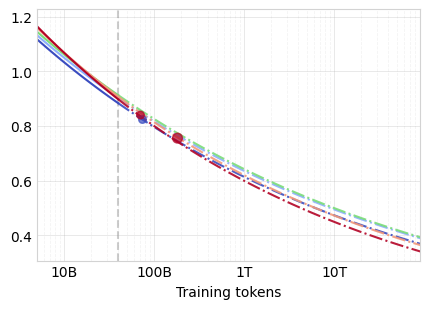

In [17]:

nll_to_bpb = 0.34124
cooldown_factor = 1.0245

fig, ax = plt.subplots(1, 1, figsize=(4.4, 3.2))

intra_tokens = np.logspace(9, np.log10(4e10), 50)
extra_tokens = np.logspace(np.log10(4e10), 14, 50)
tokens = np.logspace(9, 14, 100)

def get_color(hybrid_mixing_shift):
    return np.array(colors[hybrid_mixing_shift]) / 255.0

ax.axvline(x=4e10, color="gray", linestyle="--", alpha=0.4)

for i, (hybrid_mixing_shift, scaling_law) in enumerate(scaling_laws.items()):
    color = get_color(hybrid_mixing_shift)
    scaling_law = scaling_law[("deepseek", "tokens-opt_loss")]

    intra_opt_loss = scaling_law["func"](intra_tokens, *scaling_law["p"])
    extra_opt_loss = scaling_law["func"](extra_tokens, *scaling_law["p"])

    label = get_noise_label(hybrid_mixing_shift)
    # ax.plot(intra_tokens[-1], intra_opt_loss[-1], linestyle="none", marker="|", color=np.array(color)/255.0)

    ax.plot(intra_tokens, nll_to_bpb * intra_opt_loss / cooldown_factor, linestyle="-", color=color, label=label)
    ax.plot(extra_tokens, nll_to_bpb * extra_opt_loss / cooldown_factor, linestyle="-.", color=color, alpha=0.9)

ax.scatter([1536*2048*23500], [nll_to_bpb * 2.422], color=get_color(-1000.0), marker="o", s=30, alpha=0.7, zorder=5)
ax.scatter([1536*2048*22500, 3072*2048*29000], [nll_to_bpb * 2.462, nll_to_bpb * 2.214], color=get_color(1000.0), marker="o", s=[30, 50], alpha=0.7, zorder=5)

ax.plot([], [], linestyle="-.", color="gray", alpha=0.9, label="extrapolation")

handles, labels = ax.get_legend_handles_labels()
trend_mask = [lbl.startswith("extrapolation") for lbl in labels]
trend_handles = [h for h, m in zip(handles, trend_mask) if m]
trend_labels = [l for l, m in zip(labels, trend_mask) if m]
main_handles = [h for h, m in zip(handles, trend_mask) if not m]
main_labels = [l for l, m in zip(labels, trend_mask) if not m]

# leg_main = ax.legend(main_handles, main_labels, loc="upper right")
# ax.add_artist(leg_main)
# ax.legend(trend_handles, trend_labels, loc="lower left")

ax.set_xscale("log")
# ax.set_yscale("log")

for spine in ax.spines.values():
    spine.set_edgecolor('lightgray')
ax.tick_params(which="both", length=0, width=0)

ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.4)
ax.grid(True, which="minor", linestyle="--", linewidth=0.6, alpha=0.15)

ax.set_xlim(5e9, 9e13)
ax.set_ylim(0.34124 * 0.9, 0.34124 * 3.6)

ax.set_xticks([1e10, 1e11, 1e12, 1e13], ["10B", "100B", "1T", "10T"])

ax.set_xlabel("Training tokens")
# ax.set_ylabel("Bits-per-byte (bpb)")
fig.tight_layout()
fig.savefig("plots/data_optimal_frontier.pdf", bbox_inches="tight")

In [18]:
from notebooks.utils import params_from_config

configs = [
    (8, 8*64),
    (10, 10*64),
    (12, 12*64),
    (16, 16*64),
    (20, 12*128),
    (20, 16*128),
    (24, 20*128),
    (24, 24*128),
    (32, 32*128),
    (32, 28*128),
    (40, 32*128),
    (40, 40*128),
]
params = [params_from_config({"num_layers": l, "hidden_size": d}, include_embed_params=False) for l, d in configs]

def get_coeffs(seq_len=2048, params=params, configs=configs):
    flops_per_tok = [72 * l * d**2 + 12 * l * d * seq_len for l, d in configs]

    coeff = np.polyfit(np.log(params), np.log(flops_per_tok), 1)
    coeff_prime = np.polyfit(np.log(flops_per_tok), np.log(params), 1)
    return coeff, coeff_prime

def params_to_flops(x, seq_len=2048):
    coeff, _ = get_coeffs(seq_len=seq_len)
    return np.exp(np.polyval(coeff, np.log(x)))

def flops_to_params(x, seq_len=2048):
    _, coeff = get_coeffs(seq_len=seq_len)
    return np.exp(np.polyval(coeff, np.log(x)))

# x_fit = np.logspace(np.log10(min(params))-0.1, np.log10(max(params))+0.2, 100)
# y_fit = params_to_flops(x_fit)
# plt.plot(x_fit, y_fit, color="C3")


# plt.xlabel("non-emb. params ($P$)")
# plt.ylabel("non-emb. FLOPs/tok ($M$)")
# # plt.legend()

# plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.3)

# flops_per_tok = [72 * l * d**2 + 12 * l * d * 2048 for l, d in configs]
# plt.scatter(params, flops_per_tok)
# plt.xscale("log")
# plt.yscale("log")

In [19]:
def get_confidence_bounds(p_bootstrap, alpha=0.05):
    lower = np.percentile(p_bootstrap, 100 * (alpha / 2), axis=0)
    upper = np.percentile(p_bootstrap, 100 * (1 - alpha / 2), axis=0)
    return lower, upper

for i, hybrid_mixing_shift in enumerate(scaling_laws):
    print(get_noise_label(hybrid_mixing_shift), end="")
    for key in ["opt_flops_per_tok", "opt_tokens", "opt_loss"]:
        scaling = scaling_laws[hybrid_mixing_shift][("deepseek", key)]
        A, alpha, E = scaling["p"]
        l_bound, u_bound = get_confidence_bounds(scaling["p_bootstrap"][:, 1])
        if hybrid_mixing_shift == 1000.0:
            value = f"\\textbf{{{alpha:#.3g}}}"
        else:
            value = f"{alpha:#.3g}"
        print(f" & {value}\\textsubscript{{ [{l_bound - alpha:#.2g}, +{u_bound - alpha:#.2g}]}}", end="")
    print(" \\\\")
    # flops_scaling = scaling_laws[hybrid_mixing_shift][("deepseek", "opt_flops_per_tok")]
    # param_scaling = scaling_laws[hybrid_mixing_shift][("deepseek", "opt_params")]
    # data_scaling = scaling_laws[hybrid_mixing_shift][("deepseek", "opt_tokens")]
    # loss_scaling = scaling_laws[hybrid_mixing_shift][("deepseek", "opt_loss")]

    # l_fit, u_fit = get_confidence_bounds(scaling_laws[hybrid_mixing_shift][("deepseek", "opt_loss")]['p_bootstrap'][:, 1])

    # M_base, alpha_M, _ = flops_scaling["p"]
    # P_base, alpha_P, _ = param_scaling["p"]
    # D_base, alpha_D, _ = data_scaling["p"]
    # L_base, alpha_L, _ = loss_scaling["p"]
    # print(f"{get_noise_label(hybrid_mixing_shift)} & {alpha_L:.4f} & {alpha_D:.3f} & {alpha_M:.3f} & {alpha_P:.3f} \\\\")

masked & 0.566\textsubscript{ [-0.022, +0.020]} & 0.434\textsubscript{ [-0.020, +0.020]} & -0.0496\textsubscript{ [-0.00040, +0.00031]} \\
low-uniform & 0.535\textsubscript{ [-0.012, +0.014]} & 0.465\textsubscript{ [-0.014, +0.012]} & -0.0509\textsubscript{ [-0.00033, +0.00034]} \\
balanced & 0.534\textsubscript{ [-0.014, +0.016]} & 0.466\textsubscript{ [-0.016, +0.014]} & -0.0512\textsubscript{ [-0.00026, +0.00022]} \\
high-uniform & 0.573\textsubscript{ [-0.022, +0.027]} & 0.427\textsubscript{ [-0.027, +0.020]} & -0.0514\textsubscript{ [-0.00039, +0.00038]} \\
uniform & \textbf{0.589}\textsubscript{ [-0.020, +0.018]} & \textbf{0.411}\textsubscript{ [-0.018, +0.0011]} & \textbf{-0.0522}\textsubscript{ [-0.00029, +0.00026]} \\


In [20]:
for i, hybrid_mixing_shift in enumerate(scaling_laws):
    flops_scaling = scaling_laws[hybrid_mixing_shift][("chinchilla", "opt_flops_per_tok")]
    param_scaling = scaling_laws[hybrid_mixing_shift][("chinchilla", "opt_params")]
    data_scaling = scaling_laws[hybrid_mixing_shift][("chinchilla", "opt_tokens")]
    loss_scaling = scaling_laws[hybrid_mixing_shift][("chinchilla", "opt_loss")]
    
    M_base, alpha_M, _ = flops_scaling["p"]
    P_base, alpha_P, _ = param_scaling["p"]
    D_base, alpha_D, _ = data_scaling["p"]
    L_base, alpha_L, _ = loss_scaling["p"]
    print(f"{get_noise_label(hybrid_mixing_shift)} & {alpha_L:.4f} & {alpha_D:.3f} & {alpha_M:.3f} & {alpha_P:.3f} \\\\")

masked & -0.0462 & 0.403 & 0.597 & 0.597 \\
low-uniform & -0.0475 & 0.433 & 0.567 & 0.567 \\
balanced & -0.0479 & 0.432 & 0.568 & 0.568 \\
high-uniform & -0.0483 & 0.379 & 0.621 & 0.621 \\
uniform & -0.0490 & 0.382 & 0.618 & 0.618 \\


In [21]:
import numpy as np
from notebooks.utils import params_from_config

configs = [
    # (20, 20),
    # (24, 24),
    # (32, 32),
    # (39, 32),
    (30, 36),
    # (42, 32),
    (34, 36),
]

target_flops = 1e22
seq_len = 2048
micro_batch_size = 1024
step_mult = 1000

def round_to_nearest_multiple(x, a=1):
    bs = int(np.round(x / a)) * a
    return max(bs, a)

def ceil_to_nearest_multiple(x, a=1):
    bs = int(np.ceil(x / a)) * a
    return max(bs, a)

B_base = 3.614098626e-3
alpha_B = 0.8179

for config in configs:
    l, h = config
    d = h * 128
    M = 72 * l * d**2 + 12 * l * d * seq_len
    D = target_flops / M
    B = B_base * (D)**alpha_B
    bs = round_to_nearest_multiple(B / seq_len, micro_batch_size)
    S = ceil_to_nearest_multiple(D / (bs * seq_len), step_mult)
    flops = S * bs * seq_len * M

    params = params_from_config({"num_layers": l, "hidden_size": d}, include_embed_params=False)
    total_params = params + 2 * d * 131072
    print(f"L{l}-D{d}-H{h}: {params/1e9:.3f}B non-emb params, {total_params/1e9:.1f}B total params, {M:.3e} FLOPs/tok, {D/1e9:.2f}B tokens, {B/1e6:.1f}M tok/batch, bs={bs:.0f} ({B/seq_len:.0f}), steps={S:.0f} ({D / (bs * seq_len):.0f}), flops={flops:.2e}")

L30-D4608-H36: 7.646B non-emb params, 8.9B total params, 4.926e+10 FLOPs/tok, 203.00B tokens, 6.4M tok/batch, bs=3072 (3127), steps=33000 (32265), flops=1.02e+22
L34-D4608-H36: 8.666B non-emb params, 9.9B total params, 5.583e+10 FLOPs/tok, 179.11B tokens, 5.8M tok/batch, bs=3072 (2822), steps=29000 (28469), flops=1.02e+22


In [22]:
import numpy as np
from notebooks.utils import params_from_config

configs = [
    (26, 24),
    (28, 24),
]

target_flops = 2e21
seq_len = 2048
micro_batch_size = 512
step_mult = 500

def round_to_nearest_multiple(x, a=1):
    bs = int(np.round(x / a)) * a
    return max(bs, a)

def ceil_to_nearest_multiple(x, a=1):
    bs = int(np.ceil(x / a)) * a
    return max(bs, a)

B_base = 3.614098626e-3
alpha_B = 0.8179

for config in configs:
    l, h = config
    d = h * 128
    M = 72 * l * d**2 + 12 * l * d * seq_len
    D = target_flops / M
    B = B_base * (D)**alpha_B
    bs = round_to_nearest_multiple(B / seq_len, micro_batch_size)
    S = ceil_to_nearest_multiple(D / (bs * seq_len), step_mult)
    flops = S * bs * seq_len * M

    params = params_from_config({"num_layers": l, "hidden_size": d}, include_embed_params=False)
    total_params = params + 2 * d * 131072
    print(f"L{l}-D{d}-H{h}: {params/1e9:.3f}B non-emb params, {total_params/1e9:.1f}B total params, {M:.3e} FLOPs/tok, {D/1e9:.2f}B tokens, {B/1e6:.1f}M tok/batch, bs={bs:.0f} ({B/seq_len:.0f}), steps={S:.0f} ({D / (bs * seq_len):.0f}), flops={flops:.2e}")

L26-D3072-H24: 2.946B non-emb params, 3.8B total params, 1.963e+10 FLOPs/tok, 101.89B tokens, 3.6M tok/batch, bs=1536 (1779), steps=32500 (32389), flops=2.01e+21
L28-D3072-H24: 3.172B non-emb params, 4.0B total params, 2.114e+10 FLOPs/tok, 94.61B tokens, 3.4M tok/batch, bs=1536 (1675), steps=30500 (30076), flops=2.03e+21


In [23]:
import numpy as np
from notebooks.utils import params_from_config

configs = [
    (18, 24),
    (19, 24),
]

target_flops = 1e21
seq_len = 2048
micro_batch_size = 512
step_mult = 500

def round_to_nearest_multiple(x, a=1):
    bs = int(np.round(x / a)) * a
    return max(bs, a)

def ceil_to_nearest_multiple(x, a=1):
    bs = int(np.ceil(x / a)) * a
    return max(bs, a)

B_base = 3.614098626e-3
alpha_B = 0.8179

for config in configs:
    l, h = config
    d = h * 128
    M = 72 * l * d**2 + 12 * l * d * seq_len
    D = target_flops / M
    B = B_base * (D)**alpha_B
    bs = round_to_nearest_multiple(B / seq_len, micro_batch_size)
    S = ceil_to_nearest_multiple(D / (bs * seq_len), step_mult)
    flops = S * bs * seq_len * M

    params = params_from_config({"num_layers": l, "hidden_size": d}, include_embed_params=False)
    total_params = params + 2 * d * 131072
    print(f"L{l}-D{d}-H{h}: {params/1e9:.3f}B non-emb params, {total_params/1e9:.1f}B total params, {M:.3e} FLOPs/tok, {D/1e9:.2f}B tokens, {B/1e6:.1f}M tok/batch, bs={bs:.0f} ({B/seq_len:.0f}), steps={S:.0f} ({D / (bs * seq_len):.0f}), flops={flops:.2e}")

L18-D3072-H24: 2.039B non-emb params, 2.8B total params, 1.359e+10 FLOPs/tok, 73.59B tokens, 2.8M tok/batch, bs=1536 (1363), steps=23500 (23392), flops=1.00e+21
L19-D3072-H24: 2.152B non-emb params, 3.0B total params, 1.434e+10 FLOPs/tok, 69.71B tokens, 2.7M tok/batch, bs=1536 (1304), steps=22500 (22161), flops=1.02e+21


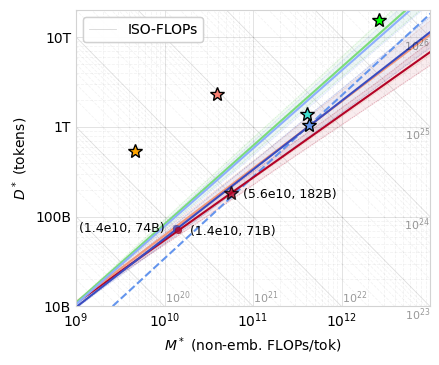

In [24]:

def get_confidence_bounds(C, flops_per_tok_law, token_law, alpha=0.05):
    opt_flops_per_tok = flops_per_tok_law["func"](C[None, :], *flops_per_tok_law["p_bootstrap"].T[..., None])
    opt_tokens = token_law["func"](C[None, :], *token_law["p_bootstrap"].T[..., None])

    opt_flops = opt_flops_per_tok * opt_tokens
    bins = (C[:-1] * C[1:])**0.5
    indices = np.digitize(opt_flops, bins)

    lower_xs, upper_xs = [], []
    lower_ys, upper_ys = [], []
    for i in range(len(C)):
        mask = indices == i

        xs = opt_flops_per_tok[mask]
        lower_x = np.percentile(xs, 100 * (alpha / 2))
        upper_x = np.percentile(xs, 100 * (1 - alpha / 2))
        lower_xs.append(lower_x)
        upper_xs.append(upper_x)

        ys = opt_tokens[mask]
        lower_y = np.percentile(ys, 100 * (alpha / 2))
        upper_y = np.percentile(ys, 100 * (1 - alpha / 2))
        lower_ys.append(lower_y)
        upper_ys.append(upper_y)
    lower_xs = np.array(lower_xs)
    upper_xs = np.array(upper_xs)
    lower_ys = np.array(lower_ys)
    upper_ys = np.array(upper_ys)

    xmin = max(lower_xs.min(), upper_xs.min())
    xmax = min(lower_xs.max(), upper_xs.max())
    xs = np.union1d(lower_xs, upper_xs)
    mask = (xs >= xmin) & (xs <= xmax)
    xs = xs[mask]

    lower = np.interp(xs, upper_xs, lower_ys)
    upper = np.interp(xs, lower_xs, upper_ys)

    return xs, lower, upper


fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.75))

trained_flops = 1e22
# trained_flops = 1e21
C = np.logspace(18, 27, 100)

M = 0.1715 * C**0.5243
D = 5.8316 * C**0.4757
ax.plot(M, D, linestyle="--", color="cornflowerblue", label="DeepSeek")

for hybrid_mixing_shift, scaling_law in list(scaling_laws.items())[::-1]:
    color = colors[hybrid_mixing_shift]

    def get_flops_per_tok(C):
        law = scaling_law[("deepseek", "opt_flops_per_tok")]
        return law["func"](C, *law["p"])
    
    def get_tokens(C):
        law = scaling_law[("deepseek", "opt_tokens")]
        return law["func"](C, *law["p"])


    flops_per_tok = get_flops_per_tok(C)
    tokens = get_tokens(C)

    xs, lower, upper = get_confidence_bounds(C, scaling_law[("deepseek", "opt_flops_per_tok")], scaling_law[("deepseek", "opt_tokens")])
    ax.fill_between(xs, lower, upper, color=np.array(color)/255.0, alpha=0.075)
    ax.plot(xs, lower, color=np.array(color)/255.0, alpha=0.3, linewidth=0.6, linestyle=":", zorder=0)
    ax.plot(xs, upper, color=np.array(color)/255.0, alpha=0.3, linewidth=0.6, linestyle=":", zorder=0)

    label = get_noise_label(hybrid_mixing_shift)
    label = None
    ax.plot(flops_per_tok, tokens, color=np.array(color)/255.0, label=label)

    if hybrid_mixing_shift == -1000.0:
        # M = get_flops_per_tok(1e21)
        # D = get_tokens(1e21)
        M = 1.359e+10
        D = 1536*2048*23500
        exponent = int(np.log10(np.abs(M)))
        mantissa  = M/10**exponent
        label = "Ours (masked)"
        label = None
        ax.plot([M], [D], "o", color=np.array(color)/255.0, markersize=5, markeredgecolor="black", markeredgewidth=0.1, zorder=3, label=label, alpha=0.8)
        ax.text(M, D, f"({mantissa:.1f}e{exponent}, {D/1e9:.0f}B)   ", fontsize=9, va="center", ha="right")

    
    if hybrid_mixing_shift == 1000.0:
        # M = get_flops_per_tok(1e21)
        # D = get_tokens(1e21)
        M = 1.434e+10
        D = 1536*2048*22500
        exponent = int(np.log10(np.abs(M)))
        mantissa  = M/10**exponent
        label = "Ours (uniform)"
        label = None
        ax.plot([M], [D], "o", color=np.array(color)/255.0, markersize=5, markeredgecolor="black", markeredgewidth=0.1, zorder=4, label=label, alpha=0.8)
        ax.text(M, D*0.9725, f"   ({mantissa:.1f}e{exponent}, {D/1e9:.0f}B)", fontsize=9, va="center", ha="left")

        # M = get_flops_per_tok(1e22)
        # D = get_tokens(1e22)
        M = 5.583e+10
        D = 3072*2048*29000
        exponent = int(np.log10(np.abs(M)))
        mantissa  = M/10**exponent
        label = "Ours (uniform)"
        label = None
        ax.plot([M], [D], "*", color=np.array(color)/255.0, markersize=10, markeredgecolor="black", markeredgewidth=1.0, zorder=4, label=label, alpha=0.8)
        ax.text(M, D*0.9725, f"   ({mantissa:.1f}e{exponent}, {D/1e9:.0f}B)", fontsize=9, va="center", ha="left")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e9, 1e13*0.9999)
ax.set_ylim(1e10, 2e13)

iso_flop_values = [1e19, 1e20, 1e21, 1e22, 1e23, 1e24, 1e25, 1e26]
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
x_line = np.logspace(np.log10(x_min), np.log10(x_max), 200)
for i, C in enumerate(iso_flop_values):
    y_line = C / x_line
    label = "ISO-FLOPs" if i == 0 else None
    label = None
    ax.plot(x_line, y_line, linestyle="-", color="black", alpha=0.13, linewidth=0.6, zorder=0, label=label)
    for i in range(2, 10):
        y_ = i * C / x_line
        ax.plot(x_line, y_, linestyle="--", color="black", alpha=0.05, linewidth=0.6, zorder=0, label=None)
    x_label = x_max
    y_label = C/x_label
    ha = "right"
    va = "top"
    if y_label < y_min:
        va = "bottom"
        y_label = y_min
        x_label = C/y_label
        ha = "left"
    if C > 1e19:
        ax.text(x_label, y_label, f"$10^{{{int(np.log10(C))}}}$", fontsize=8, va=va, ha=ha, color="black", alpha=0.4)

s = ax.plot([], [], linestyle="-", color="black", alpha=0.13, linewidth=0.6, label="ISO-FLOPs")
trend_legend = ax.legend(handles=s, loc="upper left", frameon=True)
leg = ax.add_artist(trend_legend)


ax.plot([4.3e11], [1.04e12], "*", color="cornflowerblue", markersize=10, markeredgecolor="black", markeredgewidth=1.0, label="DeepSeek 67B")
ax.plot([4.02653184e11], [1.4e12], "*", color="turquoise", markersize=10, markeredgecolor="black", markeredgewidth=1.0, label="Chinchilla 70B")
ax.plot([26.3818366157e11], [15.6e12], "*", color="lime", markersize=10, markeredgecolor="black", markeredgewidth=1.0, label="Llama 3 405B")
ax.plot([72*32*4096**2 + 12*4096*4096], [2.3e12], "*", color="salmon", markersize=10, markeredgecolor="black", markeredgewidth=1.0, label="LLaDA 8B")
ax.plot([72*20*1792**2 + 12*2048*1792], [535e9], "*", color="orange", markersize=10, markeredgecolor="black", markeredgewidth=1.0, label="Nie et al. 1.1B")


for spine in ax.spines.values():
    spine.set_edgecolor('lightgray')
ax.tick_params(which="both", length=0, width=0)


# ax.set_xticks([1e8, 1e9, 1e10, 1e11], ["100M", "1B", "10B", "100B"])
ax.set_yticks([1e10, 1e11, 1e12, 1e13], ["10B", "100B", "1T", "10T"])

ax.grid(True, which="major", linestyle="-", color="black", linewidth=0.6, alpha=0.13)
ax.grid(True, which="minor", linestyle="--", color="black", linewidth=0.6, alpha=0.05)

ax.set_xlabel("$M^*$ (non-emb. FLOPs/tok)")
ax.set_ylabel("$D^*$ (tokens)")

fig.tight_layout()
fig.savefig("plots/opt_flops_per_tok_to_tokens.pdf", bbox_inches="tight")

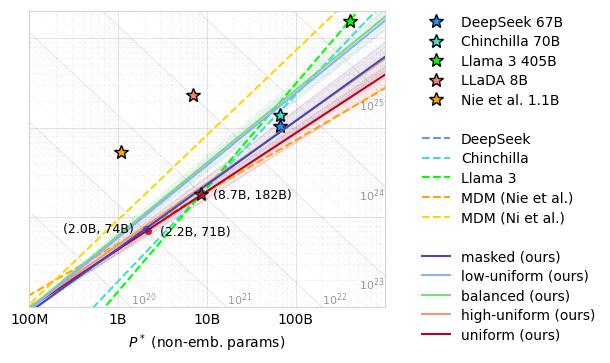

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(6.3, 3.75))

trained_flops = 1e22


C = np.logspace(17, 26, 100)

ax.plot([67e9], [1.04e12], "*", color="dodgerblue", markersize=10, markeredgecolor="black", markeredgewidth=1.0, label="DeepSeek 67B", zorder=3)
ax.plot([67e9], [1.4e12], "*", color="turquoise", markersize=10, markeredgecolor="black", markeredgewidth=1.0, label="Chinchilla 70B", zorder=3)
ax.plot([405e9], [15.6e12], "*", color="lime", markersize=10, markeredgecolor="black", markeredgewidth=1.0, label="Llama 3 405B", zorder=3)
ax.plot([6.98e9], [2.3e12], "*", color="salmon", markersize=10, markeredgecolor="black", markeredgewidth=1.0, label="LLaDA 8B", zorder=3)
ax.plot([1.082e9], [535e9], "*", color="orange", markersize=10, markeredgecolor="black", markeredgewidth=1.0, label="Nie et al. 1.1B", zorder=3)
ax.plot([], [], linestyle="none", label=" ")


# M = 0.1715 * C**0.5243
# D = 5.8316 * C**0.4757
# P = flops_to_params(M, seq_len=4096)
# ax.plot(P, D, linestyle="--", color="cornflowerblue", label="DeepSeek")
ax.plot([], [], linestyle="--", color="cornflowerblue", label="DeepSeek")


P = 0.15 * C**0.49
D = 1.15 * C**0.51
ax.plot(P, D, linestyle="--", color="turquoise", label="Chinchilla")


P = 0.6 * C**0.463
D = 0.299 * C**0.537
ax.plot(P, D, linestyle="--", color="lime", label="Llama 3")

P = 0.0001029 * C**0.634
D = 1619 * C**0.366
ax.plot(P, D, linestyle="--", color="orange", label="MDM (Nie et al.)")

P = 0.0216 * C**0.514
D = 7.7 * C**0.486
ax.plot(P, D, linestyle="--", color="gold", label="MDM (Ni et al.)")

ax.plot([], [], linestyle="none", label=" ")


for i, (hybrid_mixing_shift, scaling_law) in enumerate(scaling_laws.items()):
    def get_params(flops):
        law = scaling_law[("deepseek", "opt_flops_per_tok")]
        flops_per_tok = law["func"](flops, *law["p"])
        return flops_to_params(flops_per_tok, seq_len=2048)
    
    def get_tokens(flops):
        law = scaling_law[("deepseek", "opt_tokens")]
        return law["func"](flops, *law["p"])

    color = colors[hybrid_mixing_shift]


    # law = scaling_law["opt_flops_per_tok_interpolated"]
    # flops_per_tok = law["func"](C, *law["p"])
    # params = flops_to_params(flops_per_tok)
    params = get_params(C)

    # law = scaling_law["opt_data_interpolated"]
    # tokens = law["func"](C, *law["p"])
    tokens = get_tokens(C)

    # label = f"$P^* \\propto C^{{{P_star_alpha:.3g}}}$\n$D^* \\propto C^{{{D_star_alpha:.3g}}}$"
    label = get_noise_label(hybrid_mixing_shift) + " (ours)"
    # label = None
    ax.plot(params, tokens, color=np.array(color)/255.0, label=label, zorder=9-i)

    xs, lower, upper = get_confidence_bounds(C, scaling_law[("deepseek", "opt_flops_per_tok")], scaling_law[("deepseek", "opt_tokens")])
    ax.fill_between(flops_to_params(xs), lower, upper, color=np.array(color)/255.0, alpha=0.075)
    ax.plot(flops_to_params(xs), lower, color=np.array(color)/255.0, alpha=0.3, linewidth=0.6, linestyle=":", zorder=0)
    ax.plot(flops_to_params(xs), upper, color=np.array(color)/255.0, alpha=0.3, linewidth=0.6, linestyle=":", zorder=0)

    if hybrid_mixing_shift == -1000.0:
        # P = get_params(trained_flops)
        # D = get_tokens(trained_flops)
        P = 2.039e9
        D = 1536*2048*23500
        label = "Ours (masked)"
        label = None
        ax.plot([P], [D], "o", color=np.array(color)/255.0, markersize=5, markeredgecolor="black", markeredgewidth=0.1, zorder=15, label=label, alpha=0.8)
        ax.text(P, D, f"({P/1e9:.1f}B, {D/1e9:.0f}B)   ", fontsize=9, va="center", ha="right", zorder=15)

    
    if hybrid_mixing_shift == 1000.0:
        # P = get_params(trained_flops)
        # D = get_tokens(trained_flops)
        P = 2.152e9
        D = 1536*2048*22500
        label = "Ours (uniform)"
        label = None
        ax.plot([P], [D], "o", color=np.array(color)/255.0, markersize=5, markeredgecolor="black", markeredgewidth=0.1, zorder=15, label=label, alpha=0.8)
        ax.text(P, D*0.9725, f"   ({P/1e9:.1f}B, {D/1e9:.0f}B)", fontsize=9, va="center", ha="left", zorder=15)

        P = 8.666e9
        D = 3072*2048*29000
        label = "Ours (uniform)"
        label = None
        ax.plot([P], [D], "*", color=np.array(color)/255.0, markersize=10, markeredgecolor="black", markeredgewidth=1.0, zorder=15, label=label, alpha=0.8)
        ax.text(P, D*0.9725, f"   ({P/1e9:.1f}B, {D/1e9:.0f}B)", fontsize=9, va="center", ha="left", zorder=15)

    # print(f"{get_noise_label(hybrid_mixing_shift)}: P^* \\propto C^{{{P_star_alpha:.3g}}}, D^* \\propto C^{{{D_star_alpha:.3g}}}")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e8, 1e12*0.9999)
ax.set_ylim(1e10, 2e13)


iso_flop_values = [1e18, 1e19, 1e20, 1e21, 1e22, 1e23, 1e24, 1e25]
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
x_line = np.logspace(np.log10(x_min), np.log10(x_max), 200)
# M = 6 * x_line
# M_max = 6 * x_max
M = params_to_flops(x_line, seq_len=2048)
M_max = params_to_flops(x_max, seq_len=2048)
for i, C in enumerate(iso_flop_values):
    y_line = C / M
    label = "ISO-FLOPs" if i == 0 else None
    label = None
    ax.plot(x_line, y_line, linestyle="-", color="black", alpha=0.13, linewidth=0.6, zorder=0, label=label)
    for i in range(2, 10):
        y_ = i * C / M
        ax.plot(x_line, y_, linestyle="--", color="black", alpha=0.05, linewidth=0.6, zorder=0, label=None)
    x_label = x_max
    y_label = C/M_max
    ha = "right"
    va = "top"
    if y_label < y_min:
        va = "bottom"
        y_label = y_min
        x_label = flops_to_params(C/y_label)
        ha = "left"
    if C > 1e19:
        ax.text(x_label, y_label, f"$10^{{{int(np.log10(C))}}}$", fontsize=8, va=va, ha=ha, color="black", alpha=0.4)

for spine in ax.spines.values():
    spine.set_edgecolor('lightgray')
ax.tick_params(which="both", length=0, width=0)

ax.grid(True, which="major", linestyle="-", color="black", linewidth=0.6, alpha=0.13)
ax.grid(True, which="minor", linestyle="--", color="black", linewidth=0.6, alpha=0.05)

ax.set_xticks([1e8, 1e9, 1e10, 1e11], ["100M", "1B", "10B", "100B"])
ax.set_yticks([1e10, 1e11, 1e12, 1e13], ["", "", "", ""])

ax.set_xlabel("$P^*$ (non-emb. params)")
# ax.set_ylabel("$D^*$ (tokens)")
# ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), labelspacing=1.0)
ax.legend(loc="upper left", bbox_to_anchor=(1.07, 1.03), frameon=False, labelspacing=0.4,)
fig.tight_layout()
fig.savefig("plots/opt_params_to_tokens.pdf", bbox_inches="tight")

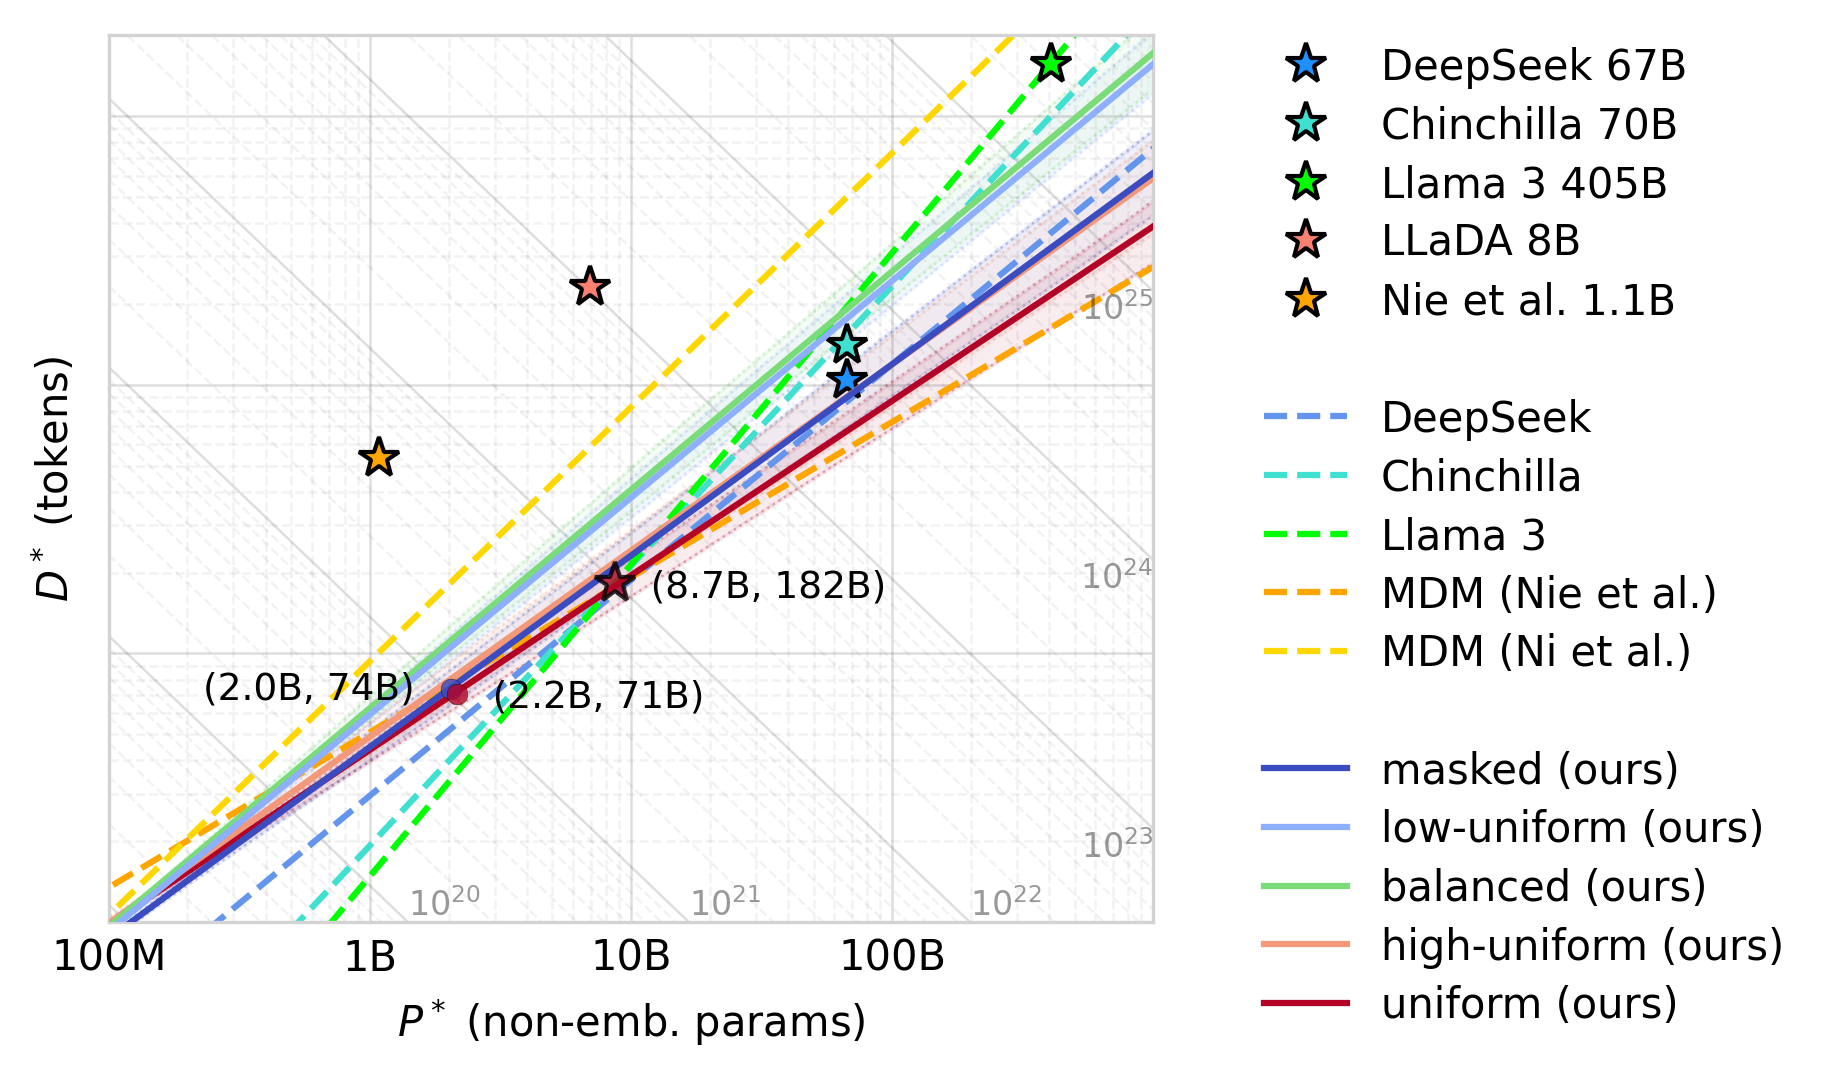

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6.3, 3.75), dpi=300)

trained_flops = 1e22


C = np.logspace(17, 26, 100)

ax.plot([67e9], [1.04e12], "*", color="dodgerblue", markersize=10, markeredgecolor="black", markeredgewidth=1.0, label="DeepSeek 67B", zorder=3)
ax.plot([67e9], [1.4e12], "*", color="turquoise", markersize=10, markeredgecolor="black", markeredgewidth=1.0, label="Chinchilla 70B", zorder=3)
ax.plot([405e9], [15.6e12], "*", color="lime", markersize=10, markeredgecolor="black", markeredgewidth=1.0, label="Llama 3 405B", zorder=3)
ax.plot([6.98e9], [2.3e12], "*", color="salmon", markersize=10, markeredgecolor="black", markeredgewidth=1.0, label="LLaDA 8B", zorder=3)
ax.plot([1.082e9], [535e9], "*", color="orange", markersize=10, markeredgecolor="black", markeredgewidth=1.0, label="Nie et al. 1.1B", zorder=3)
ax.plot([], [], linestyle="none", label=" ")


M = 0.1715 * C**0.5243
D = 5.8316 * C**0.4757
P = flops_to_params(M, seq_len=4096)
ax.plot(P, D, linestyle="--", color="cornflowerblue", label="DeepSeek")
# ax.plot([], [], linestyle="--", color="cornflowerblue", label="DeepSeek")


P = 0.15 * C**0.49
D = 1.15 * C**0.51
ax.plot(P, D, linestyle="--", color="turquoise", label="Chinchilla")


P = 0.6 * C**0.463
D = 0.299 * C**0.537
ax.plot(P, D, linestyle="--", color="lime", label="Llama 3")

P = 0.0001029 * C**0.634
D = 1619 * C**0.366
ax.plot(P, D, linestyle="--", color="orange", label="MDM (Nie et al.)")

P = 0.0216 * C**0.514
D = 7.7 * C**0.486
ax.plot(P, D, linestyle="--", color="gold", label="MDM (Ni et al.)")

ax.plot([], [], linestyle="none", label=" ")


for i, (hybrid_mixing_shift, scaling_law) in enumerate(scaling_laws.items()):
    def get_params(flops):
        law = scaling_law[("deepseek", "opt_flops_per_tok")]
        flops_per_tok = law["func"](flops, *law["p"])
        return flops_to_params(flops_per_tok, seq_len=2048)
    
    def get_tokens(flops):
        law = scaling_law[("deepseek", "opt_tokens")]
        return law["func"](flops, *law["p"])

    color = colors[hybrid_mixing_shift]


    # law = scaling_law["opt_flops_per_tok_interpolated"]
    # flops_per_tok = law["func"](C, *law["p"])
    # params = flops_to_params(flops_per_tok)
    params = get_params(C)

    # law = scaling_law["opt_data_interpolated"]
    # tokens = law["func"](C, *law["p"])
    tokens = get_tokens(C)

    # label = f"$P^* \\propto C^{{{P_star_alpha:.3g}}}$\n$D^* \\propto C^{{{D_star_alpha:.3g}}}$"
    label = get_noise_label(hybrid_mixing_shift) + " (ours)"
    # label = None
    ax.plot(params, tokens, color=np.array(color)/255.0, label=label, zorder=9-i)

    xs, lower, upper = get_confidence_bounds(C, scaling_law[("deepseek", "opt_flops_per_tok")], scaling_law[("deepseek", "opt_tokens")])
    ax.fill_between(flops_to_params(xs), lower, upper, color=np.array(color)/255.0, alpha=0.075)
    ax.plot(flops_to_params(xs), lower, color=np.array(color)/255.0, alpha=0.3, linewidth=0.6, linestyle=":", zorder=0)
    ax.plot(flops_to_params(xs), upper, color=np.array(color)/255.0, alpha=0.3, linewidth=0.6, linestyle=":", zorder=0)

    if hybrid_mixing_shift == -1000.0:
        # P = get_params(trained_flops)
        # D = get_tokens(trained_flops)
        P = 2.039e9
        D = 1536*2048*23500
        label = "Ours (masked)"
        label = None
        ax.plot([P], [D], "o", color=np.array(color)/255.0, markersize=5, markeredgecolor="black", markeredgewidth=0.1, zorder=15, label=label, alpha=0.8)
        ax.text(P, D, f"({P/1e9:.1f}B, {D/1e9:.0f}B)   ", fontsize=9, va="center", ha="right", zorder=15)

    
    if hybrid_mixing_shift == 1000.0:
        # P = get_params(trained_flops)
        # D = get_tokens(trained_flops)
        P = 2.152e9
        D = 1536*2048*22500
        label = "Ours (uniform)"
        label = None
        ax.plot([P], [D], "o", color=np.array(color)/255.0, markersize=5, markeredgecolor="black", markeredgewidth=0.1, zorder=15, label=label, alpha=0.8)
        ax.text(P, D*0.9725, f"   ({P/1e9:.1f}B, {D/1e9:.0f}B)", fontsize=9, va="center", ha="left", zorder=15)

        P = 8.666e9
        D = 3072*2048*29000
        label = "Ours (uniform)"
        label = None
        ax.plot([P], [D], "*", color=np.array(color)/255.0, markersize=10, markeredgecolor="black", markeredgewidth=1.0, zorder=15, label=label, alpha=0.8)
        ax.text(P, D*0.9725, f"   ({P/1e9:.1f}B, {D/1e9:.0f}B)", fontsize=9, va="center", ha="left", zorder=15)

    # print(f"{get_noise_label(hybrid_mixing_shift)}: P^* \\propto C^{{{P_star_alpha:.3g}}}, D^* \\propto C^{{{D_star_alpha:.3g}}}")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e8, 1e12*0.9999)
ax.set_ylim(1e10, 2e13)


iso_flop_values = [1e18, 1e19, 1e20, 1e21, 1e22, 1e23, 1e24, 1e25]
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
x_line = np.logspace(np.log10(x_min), np.log10(x_max), 200)
# M = 6 * x_line
# M_max = 6 * x_max
M = params_to_flops(x_line, seq_len=2048)
M_max = params_to_flops(x_max, seq_len=2048)
for i, C in enumerate(iso_flop_values):
    y_line = C / M
    label = "ISO-FLOPs" if i == 0 else None
    label = None
    ax.plot(x_line, y_line, linestyle="-", color="black", alpha=0.13, linewidth=0.6, zorder=0, label=label)
    for i in range(2, 10):
        y_ = i * C / M
        ax.plot(x_line, y_, linestyle="--", color="black", alpha=0.05, linewidth=0.6, zorder=0, label=None)
    x_label = x_max
    y_label = C/M_max
    ha = "right"
    va = "top"
    if y_label < y_min:
        va = "bottom"
        y_label = y_min
        x_label = flops_to_params(C/y_label)
        ha = "left"
    if C > 1e19:
        ax.text(x_label, y_label, f"$10^{{{int(np.log10(C))}}}$", fontsize=8, va=va, ha=ha, color="black", alpha=0.4)

for spine in ax.spines.values():
    spine.set_edgecolor('lightgray')
ax.tick_params(which="both", length=0, width=0)

ax.grid(True, which="major", linestyle="-", color="black", linewidth=0.6, alpha=0.13)
ax.grid(True, which="minor", linestyle="--", color="black", linewidth=0.6, alpha=0.05)

ax.set_xticks([1e8, 1e9, 1e10, 1e11], ["100M", "1B", "10B", "100B"])
ax.set_yticks([1e10, 1e11, 1e12, 1e13], ["", "", "", ""])

ax.set_xlabel("$P^*$ (non-emb. params)")
ax.set_ylabel("$D^*$ (tokens)")
# ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), labelspacing=1.0)
ax.legend(loc="upper left", bbox_to_anchor=(1.07, 1.03), frameon=False, labelspacing=0.4,)
fig.tight_layout()
fig.show()
# fig.savefig("plots/opt_params_to_tokens.pdf", bbox_inches="tight")

KeyError: 'p'

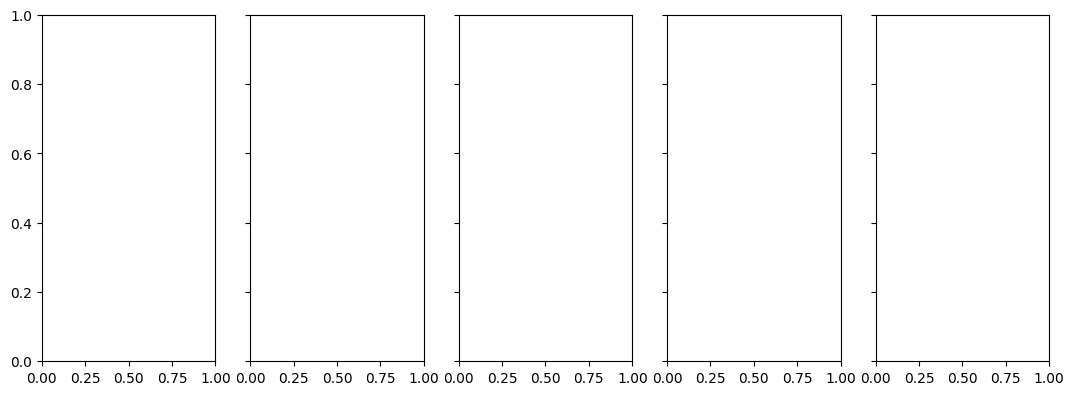

In [26]:
fig, axs = plt.subplots(1, 5, figsize=(13, 4.5), sharex=True, sharey="row")

vmin, vmax = 2.37, 4.7
cmap = "magma_r"
norm = plt.Normalize(vmin=vmin, vmax=vmax)

flops = np.logspace(17, 23, 100)
params = np.logspace(7, 11, 100)
X, Y = np.meshgrid(flops, params)
tokens = X / (6 * Y)



def eval_bootstrap_params(bootstrap_array, flops, percentile_alpha=15.85):
    a, alpha, b, beta, E = bootstrap_array[:,:,None]
    # L_star_P = E + a*(alpha + beta)/beta * params[None,:]**(-alpha)
    p_opt = ((alpha*a)/(beta*b))**(1/(alpha+beta)) * (flops/6)**(beta/(alpha+beta))
    lower = np.percentile(p_opt, percentile_alpha, axis=0)
    upper = np.percentile(p_opt, 100 - percentile_alpha, axis=0)
    return lower, upper




for i, (hybrid_mixing_shift, scaling_law) in enumerate(scaling_laws.items()):
    ax = axs[i]
    a, alpha, b, beta, E = scaling_law["p"]
    loss = E + a * Y**-alpha + b * tokens**-beta

    levels = np.logspace(np.log10(vmin), np.log10(vmax), 20)
    # levels = np.concatenate([np.array([0.0]), levels])
    ax.contourf(X, Y, loss, levels=levels, cmap=cmap, norm=norm)

    p_opt = ((alpha*a)/(beta*b))**(1/(alpha+beta)) * (flops/6)**(beta/(alpha+beta))
    expo = beta/(alpha+beta)
    C_star_alpha = (-(alpha*beta)/(alpha + beta))

    color = (0.1, 0.4, 1.0)
    ax.plot(flops, p_opt, linestyle="-", color=color, label="$L^*(C) \\propto C^{{{:.4g}}}$".format(C_star_alpha))


    lower, upper = eval_bootstrap_params(scaling_law["p_bootstrap"].T, flops)
    ax.fill_between(flops, lower, upper, alpha=0.2, color=color)

    dfi = df_.filter(pl.col("hybrid_mixing_shift") == hybrid_mixing_shift)
    ps, ts, ls = dfi["non_emb_params"], dfi["tokens"], dfi["target_loss"]
    ax.scatter(6*ps*ts, ps, c=ls, cmap=cmap, norm=norm, edgecolor=(0,0,0,0.3), linewidth=0.5, s=10, zorder=2)
    
    # ax.plot([], [], "-", color=(0.0, 0.0, 0.0, 0.3), label=f"")

    ax.set_xscale("log"); ax.set_yscale("log")
    ax.set_title(get_noise_label(hybrid_mixing_shift))
    ax.set_ylim(1e7, 1e11)
    ax.set_xlim(2e17, 1e23)
    if i == 0: ax.set_ylabel("$P$ (non-emb. params)")
    ax.set_xlabel("$C$ (FLOPs)")
    ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.2, color="black")
    ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.05, color="black")


    ax.legend(loc="upper left")


for ax in axs.flatten():
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgray')
    ax.tick_params(which="both", length=0, width=0)

fig.tight_layout(w_pad=0.2)

box = axs[-1].get_position()
cax_w, pad = 0.018, 0.015
cax = fig.add_axes([box.x0 + box.width + pad, box.y0, cax_w, box.height])
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
fig.colorbar(sm, cax=cax, label="$L$ (ELBO)")
cax.yaxis.set_ticks_position('right'); cax.yaxis.set_label_position('right')

fig.savefig("plots/params_vs_flops.pdf", bbox_inches="tight")


masked: $L^*(C) = 10^{2.347} \cdot C^{-0.1313} + 2.153$
low-uniform: $L^*(C) = 10^{2.41} \cdot C^{-0.1345} + 2.178$
balanced: $L^*(C) = 10^{2.297} \cdot C^{-0.1263} + 2.122$
high-uniform: $L^*(C) = 10^{2.084} \cdot C^{-0.1117} + 2.013$
uniform: $L^*(C) = 10^{2.018} \cdot C^{-0.1065} + 1.940$


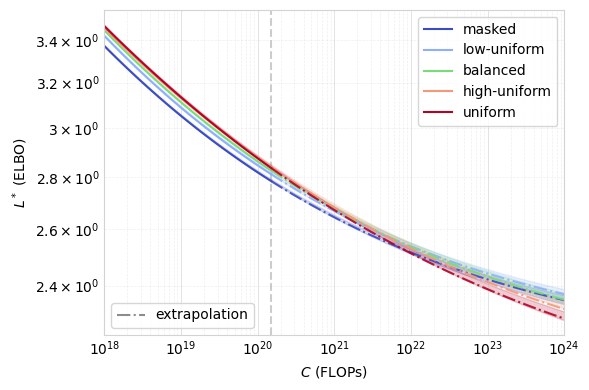

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.0))

intra_flops = np.logspace(18, np.log10(1.5e20), 50)
extra_flops = np.logspace(np.log10(1.5e20), 24, 50)
flops = np.logspace(18, 24, 100)

idx = np.argmin(np.abs(flops - 1.5e20))

ax.axvline(x=1.5e20, color="gray", linestyle="--", alpha=0.4)
ax.plot([], [], linestyle="-.", color="gray", alpha=0.9, label="extrapolation")

def eval_bootstrap_flops(bootstrap_array, flops, percentile_alpha=15.85):
    a, alpha, b, beta, E = bootstrap_array[:,:,None]
    C_star_a = (alpha + beta) * (a/beta)**(beta/(alpha + beta)) * (b/alpha)**(alpha/(alpha + beta))
    C_star_alpha = (-(alpha*beta)/(alpha + beta))

    L_star_C = E + C_star_a * (flops[None,:]/6)**C_star_alpha
    lower = np.percentile(L_star_C, percentile_alpha, axis=0)
    upper = np.percentile(L_star_C, 100 - percentile_alpha, axis=0)
    return lower, upper

for i, (hybrid_mixing_shift, scaling_law) in enumerate(scaling_laws.items()):
    color = colors[hybrid_mixing_shift]

    a, alpha, b, beta, E = scaling_law["p"]
    C_star_a = (alpha + beta) * (a/beta)**(beta/(alpha + beta)) * (b/alpha)**(alpha/(alpha + beta))
    C_star_alpha = (-(alpha*beta)/(alpha + beta))

    lower_intra, upper_intra = eval_bootstrap_flops(scaling_law["p_bootstrap"].T, intra_flops)
    L_star_C_intra = E + C_star_a * (intra_flops/6)**C_star_alpha
    lower_extra, upper_extra = eval_bootstrap_flops(scaling_law["p_bootstrap"].T, extra_flops)
    L_star_C_extra = E + C_star_a * (extra_flops/6)**C_star_alpha


    # if hybrid_mixing_shift == -1000.0:
    #     C = 5e21
    #     L = E + C_star_a * (C/6)**C_star_alpha
    #     ax.plot([C], [L], ".", color=np.array(color)/255.0, zorder=10)
    #     ax.axhline(y=L, color=np.array(color)/255.0, linestyle="-", alpha=0.4, linewidth=1.0)
    #     ax.text(1e18, L, f" {L:.3f}", fontsize=8, va="bottom", ha="left", color=np.array(color)/255.0, alpha=0.8)

    
    # if hybrid_mixing_shift == 1000.0:
    #     C = 5e21
    #     L = E + C_star_a * (C/6)**C_star_alpha
    #     ax.plot([C], [L], ".", color=np.array(color)/255.0, zorder=10)
    #     ax.axhline(y=L, color=np.array(color)/255.0, linestyle="-", alpha=0.4, linewidth=1.0)
    #     ax.text(1e18, L*0.996, f" {L:.3f}", fontsize=8, va="top", ha="left", color=np.array(color)/255.0, alpha=0.8)

    label = get_noise_label(hybrid_mixing_shift)
    ax.plot(intra_flops, L_star_C_intra, linestyle="-", color=np.array(color)/255.0, label=label)
    ax.fill_between(intra_flops, lower_intra, upper_intra, alpha=0.2, color=np.array(color)/255.0)
    ax.plot(extra_flops, L_star_C_extra, linestyle="-.", color=np.array(color)/255.0, alpha=0.9)
    ax.fill_between(extra_flops, lower_extra, upper_extra, alpha=0.2, color=np.array(color)/255.0)

    print(get_noise_label(hybrid_mixing_shift) + ": $L^*(C) = 10^{{{:.4g}}} \\cdot C^{{{:.4g}}} + {:.3f}$".format(np.log10(C_star_a), C_star_alpha, E))


handles, labels = ax.get_legend_handles_labels()
trend_mask = [lbl.startswith("extrapolation") for lbl in labels]
trend_handles = [h for h, m in zip(handles, trend_mask) if m]
trend_labels = [l for l, m in zip(labels, trend_mask) if m]
main_handles = [h for h, m in zip(handles, trend_mask) if not m]
main_labels = [l for l, m in zip(labels, trend_mask) if not m]

leg_main = ax.legend(main_handles, main_labels, loc="upper right")
ax.add_artist(leg_main)
ax.legend(trend_handles, trend_labels, loc="lower left")

ax.set_xscale("log")
ax.set_yscale("log")
# ax.legend()


# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)



for spine in ax.spines.values():
    spine.set_edgecolor('lightgray')
ax.tick_params(which="both", length=0, width=0)

ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5)
ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.2)

ax.set_xlim(1e18, 1e24)

ax.set_xlabel("$C$ (FLOPs)")
ax.set_ylabel("$L^*$ (ELBO)")
fig.tight_layout()
fig.savefig("plots/compute_optimal_frontier.pdf", bbox_inches="tight")

masked: P^* \propto C^{0.588}, D^* \propto C^{0.412}
low-uniform: P^* \propto C^{0.563}, D^* \propto C^{0.437}
balanced: P^* \propto C^{0.567}, D^* \propto C^{0.433}
high-uniform: P^* \propto C^{0.614}, D^* \propto C^{0.386}
uniform: P^* \propto C^{0.625}, D^* \propto C^{0.375}


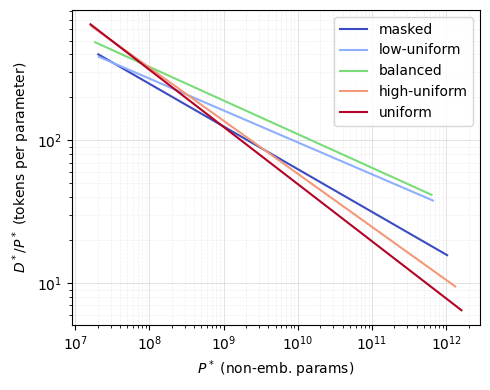

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

def bootstrap_flops_on_params(bootstrap_array, flops, percentile_alpha=15.85):
    a, alpha, b, beta, E = bootstrap_array[:,:,None]
    P_star_a, P_star_alpha = ((a*alpha)/(b*beta))**(1/(alpha + beta)), (beta/(alpha + beta))
    D_star_a, D_star_alpha = ((b*beta)/(a*alpha))**(1/(alpha + beta)), (alpha/(alpha + beta))

    params = P_star_a * (flops[None,:]/6)**P_star_alpha
    tokens = D_star_a * (flops[None,:]/6)**D_star_alpha

    # # bin and hist
    # params = params.ravel()
    # tokens = tokens.ravel()
    # n_bins = 100
    # bins = np.logspace(8, 11, n_bins + 1)
    #
    # # Assign bins (idx in [0, n_bins-1]); drop out-of-range and non-finite
    # idx = np.digitize(params, bins) - 1
    # valid = (idx >= 0) & (idx < n_bins) & np.isfinite(params) & np.isfinite(tokens)
    # x, y, idx = params[valid], tokens[valid], idx[valid]
    #
    # # Prepare outputs
    # counts = np.bincount(idx, minlength=n_bins)
    # q = np.array([percentile_alpha, 100 - percentile_alpha])
    # out = np.full((n_bins, q.size), np.nan)
    #
    # # Compute percentiles per bin
    # for i in range(n_bins):
    #     if counts[i] < 1:
    #         continue
    #     yi = y[idx == i]
    #     if yi.size == 0:
    #         continue
    #     else:
    #         out[i] = np.percentile(yi, q)
    #
    # # Bin centers (geometric is handy for log-scaled x)
    # bin_center = np.sqrt(bins[:-1] * bins[1:])
    #
    # return bin_center, out[:,0], out[:,1]

    med_p = np.percentile(params, 50.0, axis=0)
    lo_d, hi_d = np.percentile(tokens, [percentile_alpha, 100.0 - percentile_alpha], axis=0)
    return med_p, lo_d, hi_d



for hybrid_mixing_shift, scaling_law in scaling_laws.items():
    color = colors[hybrid_mixing_shift]

    a, alpha, b, beta, E = scaling_law["p"]
    P_star_a, P_star_alpha = ((a*alpha)/(b*beta))**(1/(alpha + beta)), (beta/(alpha + beta))
    D_star_a, D_star_alpha = ((b*beta)/(a*alpha))**(1/(alpha + beta)), (alpha/(alpha + beta))

    flops = np.logspace(18, 26, 100)
    params = P_star_a * (flops/6)**P_star_alpha
    tokens = D_star_a * (flops/6)**D_star_alpha

    # label = f"$P^* \\propto C^{{{P_star_alpha:.3g}}}$\n$D^* \\propto C^{{{D_star_alpha:.3g}}}$"
    label = get_noise_label(hybrid_mixing_shift)
    ax.plot(params, tokens/params, color=np.array(color)/255.0, label=label)

    # do the bootstrop
    # med_p, lo_d, hi_d = bootstrap_flops_on_params(scaling_law["p_bootstrap"].T, flops)
    # ax.fill_between(med_p, lo_d, hi_d, alpha=0.25, color=np.array(color)/255.0)

    print(f"{get_noise_label(hybrid_mixing_shift)}: P^* \\propto C^{{{P_star_alpha:.3g}}}, D^* \\propto C^{{{D_star_alpha:.3g}}}")



ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlim(1e8, 1e11)
# ax.set_ylim(3e10, 2e13)

ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5)
ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.2)

ax.set_xlabel("$P^*$ (non-emb. params)")
ax.set_ylabel("$D^*/P^*$ (tokens per parameter)")
# ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), labelspacing=1.0)
ax.legend()
fig.tight_layout()
#fig.savefig("plots/opt_params_tokens.pdf", bbox_inches="tight")

masked: P^* \propto C^{0.588}, D^* \propto C^{0.412}
low-uniform: P^* \propto C^{0.563}, D^* \propto C^{0.437}
balanced: P^* \propto C^{0.564}, D^* \propto C^{0.436}
high-uniform: P^* \propto C^{0.614}, D^* \propto C^{0.386}
uniform: P^* \propto C^{0.625}, D^* \propto C^{0.375}


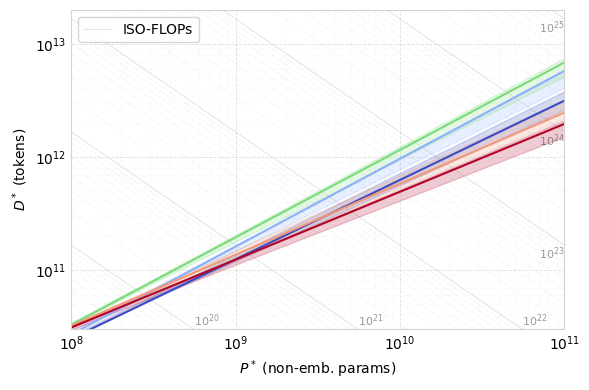

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

trained_flops = 5e21


def bootstrap_flops_on_params(bootstrap_array, flops, percentile_alpha=15.85):
    a, alpha, b, beta, E = bootstrap_array[:,:,None]
    P_star_a, P_star_alpha = ((a*alpha)/(b*beta))**(1/(alpha + beta)), (beta/(alpha + beta))
    D_star_a, D_star_alpha = ((b*beta)/(a*alpha))**(1/(alpha + beta)), (alpha/(alpha + beta))

    params = P_star_a * (flops[None,:]/6)**P_star_alpha
    tokens = D_star_a * (flops[None,:]/6)**D_star_alpha

    # # bin and hist
    # params = params.ravel()
    # tokens = tokens.ravel()
    # n_bins = 100
    # bins = np.logspace(8, 11, n_bins + 1)
    #
    # # Assign bins (idx in [0, n_bins-1]); drop out-of-range and non-finite
    # idx = np.digitize(params, bins) - 1
    # valid = (idx >= 0) & (idx < n_bins) & np.isfinite(params) & np.isfinite(tokens)
    # x, y, idx = params[valid], tokens[valid], idx[valid]
    #
    # # Prepare outputs
    # counts = np.bincount(idx, minlength=n_bins)
    # q = np.array([percentile_alpha, 100 - percentile_alpha])
    # out = np.full((n_bins, q.size), np.nan)
    #
    # # Compute percentiles per bin
    # for i in range(n_bins):
    #     if counts[i] < 1:
    #         continue
    #     yi = y[idx == i]
    #     if yi.size == 0:
    #         continue
    #     else:
    #         out[i] = np.percentile(yi, q)
    #
    # # Bin centers (geometric is handy for log-scaled x)
    # bin_center = np.sqrt(bins[:-1] * bins[1:])
    #
    # return bin_center, out[:,0], out[:,1]

    med_p = np.percentile(params, 50.0, axis=0)
    lo_d, hi_d = np.percentile(tokens, [percentile_alpha, 100.0 - percentile_alpha], axis=0)
    return med_p, lo_d, hi_d

for hybrid_mixing_shift, scaling_law in scaling_laws.items():
    color = colors[hybrid_mixing_shift]


    a, alpha, b, beta, E = scaling_law["p"]
    P_star_a, P_star_alpha = ((a*alpha)/(b*beta))**(1/(alpha + beta)), (beta/(alpha + beta))
    D_star_a, D_star_alpha = ((b*beta)/(a*alpha))**(1/(alpha + beta)), (alpha/(alpha + beta))

    flops = np.logspace(18, 26, 100)
    params = P_star_a * (flops/6)**P_star_alpha
    tokens = D_star_a * (flops/6)**D_star_alpha

    # label = f"$P^* \\propto C^{{{P_star_alpha:.3g}}}$\n$D^* \\propto C^{{{D_star_alpha:.3g}}}$"
    label = get_noise_label(hybrid_mixing_shift)
    label = None
    ax.plot(params, tokens, color=np.array(color)/255.0, label=label)

    # do the bootstrop
    med_p, lo_d, hi_d = bootstrap_flops_on_params(scaling_law["p_bootstrap"].T, flops)
    ax.fill_between(med_p, lo_d, hi_d, alpha=0.2, color=np.array(color)/255.0)
    
    # if hybrid_mixing_shift == -1000.0:
    #     P = P_star_a * (trained_flops/6)**P_star_alpha
    #     D = D_star_a * (trained_flops/6)**D_star_alpha
    #     ax.plot([P], [D], "o", color=np.array(color)/255.0)
    #     ax.text(P, D, f"  ({P/1e9:.1f}B, {D/1e9:.0f}B)", fontsize=8, va="top", ha="left")

    
    # if hybrid_mixing_shift == 1000.0:
    #     P = P_star_a * (trained_flops/6)**P_star_alpha
    #     D = D_star_a * (trained_flops/6)**D_star_alpha
    #     ax.plot([P], [D], "o", color=np.array(color)/255.0)
    #     ax.text(P, D, f"   ({P/1e9:.1f}B, {D/1e9:.0f}B)", fontsize=8, va="top", ha="left")

    print(f"{get_noise_label(hybrid_mixing_shift)}: P^* \\propto C^{{{P_star_alpha:.3g}}}, D^* \\propto C^{{{D_star_alpha:.3g}}}")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e8, 1e11)
ax.set_ylim(3e10, 2e13)

iso_flop_values = [1e19, 1e20, 1e21, 1e22, 1e23, 1e24, 1e25]
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
x_line = np.logspace(np.log10(x_min), np.log10(x_max), 200)
for i, C in enumerate(iso_flop_values):
    y_line = (C/6.0) / x_line
    label = "ISO-FLOPs" if i == 0 else None
    ax.plot(x_line, y_line, linestyle="-", color="black", alpha=0.13, linewidth=0.6, zorder=0, label=label)
    for i in range(2, 10):
        y_ = i * (C/6.0) / x_line
        ax.plot(x_line, y_, linestyle="--", color="black", alpha=0.05, linewidth=0.6, zorder=0, label=None)
    x_label = x_max
    y_label = (C/6.0)/x_label
    ha = "right"
    va = "top"
    if y_label < y_min:
        va = "bottom"
        y_label = y_min
        x_label = (C/6.0)/y_label
        # if C == 1e21:
        #     ha = "right"
        #     x_label = x_label * 0.7
        # else:
        #     ha = "left"
        ha = "left"
    # if not (y_min < y_label < y_max):
    #     x_label = x_min*1.5
    #     y_label = (C/6.0)/x_label
    if C > 1e19:
        ax.text(x_label, y_label, f"$10^{{{int(np.log10(C))}}}$", fontsize=8, va=va, ha=ha, color="black", alpha=0.4)

# iso_flop_values = [5e21]
# for i, C in enumerate(iso_flop_values):
#     y_line = (C/6.0) / x_line
#     label = None
#     ax.plot(x_line, y_line, linestyle=":", color="gray", alpha=0.8, linewidth=1.0, zorder=0, label=label)

#     ha = "right"
#     va = "bottom"
#     y_label = y_min
#     x_label = (C/6.0)/y_label * 0.73
#     # if not (y_min < y_label < y_max):
#     #     x_label = x_min*1.5
#     #     y_label = (C/6.0)/x_label
#     ax.text(x_label, y_label, "$5 \\times 10^{21}$", fontsize=8, va=va, ha=ha, color="gray", alpha=0.9)


for spine in ax.spines.values():
    spine.set_edgecolor('lightgray')
ax.tick_params(which="both", length=0, width=0)


# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

ax.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.4)
ax.grid(True, which="minor", linestyle=":", linewidth=0.8, alpha=0.1)

ax.set_xlabel("$P^*$ (non-emb. params)")
ax.set_ylabel("$D^*$ (tokens)")
# ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), labelspacing=1.0)
ax.legend(loc="upper left")
fig.tight_layout()
fig.savefig("plots/opt_params_tokens.pdf", bbox_inches="tight")